In [1]:
# load necessary libraries

# -*- coding: utf-8 -*-
%load_ext autoreload
%autoreload 2

import os, time
# select GPU for training
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# import tensorflow.experimental.numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import random
import scipy.io as scio
import h5py 
import math

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)
    
import sys
sys.path.append("../../")
import lib
from lib.proc import *
from lib.simu import *
from lib.commons import *
from lib.net import *




In [2]:
# hyper parameters definition
LENGTH = 130
CV_SP = 0
reg = 1e-2
prefix = "T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len%s-CV%s-RoQ-timesensitivity-checkdata-relusigmoid"%(str(LENGTH),str(CV_SP))
ISTRAIN = False
sample_pattern = 'RES01'
# parameters to set
DCE_DIM = 360
INIT_DIM = 4

OUT_DIM = LENGTH
IN_DIM = OUT_DIM
PK_DIM = 2

BATCH_SIZE = 1 # 
LR_RATE = 1e-3

LAYER_NUM = 4
FEATURE_NUM = 64

hct=0.4
del_t = 2 

print(prefix)

mainfolder = "/hdd1/chaowei/data/dce/pancreas_syn_purified_linCA_wt_bdTK_VARPRO/"
train_ind,test_ind = get_train_test_index(CV_SP,10)
print(train_ind,test_ind)


T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-CV0-RoQ-timesensitivity-checkdata-relusigmoid
[1, 2, 3, 4, 5, 6, 7, 8, 9] 0


In [3]:
# load models 

model_upsample = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Upsample_XAIF_wt_constraint_pancreas_cv00.h5')
model_deconv = load_model('/hdd1/chaowei/dce-dl/checkpoint/saved_model/Deconv_dense_fast_pancreas.h5')


In [14]:
import multiprocessing as mp
from scipy.optimize import least_squares
import logging

logging.basicConfig(level=logging.INFO, format='%(processName)s: %(message)s')

def least_squares_optimization(c_pl, c_pan, x0, ind, mode, del_t):
    c_pl_use = c_pl
    c_pan_use = c_pan

    def fun_to_fit_VARPRO(x):
        return fun_oritofts_VARPRO(c_pl_use, c_pan_use[ind,:], x, del_t=del_t)

    result = least_squares(fun_to_fit_VARPRO, x0=x0, bounds=((1e-4), (0.4)))
    temp = g_VARPRO(c_pl_use, c_pan_use[ind,:], result.x, del_t = del_t)

    residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
    pfit = np.array([temp, result.x[0], temp/result.x[0], time.time()-timenow, residual]).reshape(1, 5)
    
    logging.info(f'Finished optimization for index {ind} in mode {mode}')

    return pfit

def fit_pred_test_pk_parallel(c_pl_pred, c_pan_pred, del_t=None): 
    numel = c_pan_pred.shape[0]
    pfit_pred = []
    pool = mp.Pool(mp.cpu_count())  # create a pool of processes

    results_pred = pool.starmap(least_squares_optimization, [(c_pl_pred, c_pan_pred, np.array([0.01]), ind, "pred", del_t) for ind in range(numel)])

    pool.close()  # close the pool
    pool.join()   # wait for all processes to finish

    for res in results_pred:
        if res is not None:
            pfit_pred.append(res)
            
    pfit_pred = np.concatenate(pfit_pred, axis=0) if pfit_pred else np.zeros((numel,5))
    print(pfit_pred[0:3])
    return pfit_pred



# use GT to get pk from pretrained and from VARPRO 
def fit_pred_test_pk(c_pl_pred, c_pan_pred, del_t=None): 
    from scipy.optimize import least_squares
    c_pl_pred = c_pl_pred[0,:]
    numel = c_pan_pred.shape[0]
    pfit_pred = np.zeros((numel,5))
    for ind in range(numel):
#         try:
        def fun_to_fit_VARPRO(x):
            return fun_oritofts_VARPRO(c_pl_pred, c_pan_pred[ind,:],x,del_t=del_t)

        timenow = time.time()
        if ind%100==0: print(f"Start fitting for prediction index: {ind}") 
        result = least_squares(fun_to_fit_VARPRO, x0 = np.array([0.01]),bounds=((1e-4),(0.4)))
        temp = g_VARPRO(c_pl_pred,c_pan_pred[ind,:],result.x,del_t=del_t)

        residual = tf.reduce_mean((fun_to_fit_VARPRO(result.x))**2).numpy()
        pfit_pred = np.append(pfit_pred,np.array([temp,result.x[0],temp/result.x[0],time.time()-timenow,residual]).reshape(1,5),axis=0)
        if ind%100==0: print(f"Finished fitting for prediction index: {ind}") 
#         except:
#             print(f"An error occurred in fitting index: {ind}")
#             continue
    return pfit_pred


def permute_tf_tensor(t):

    # Create a tensor that represents the new order of your columns
    indices = tf.constant([2, 0, 1])

    # Use tf.gather to rearrange the columns of your tensor
    t_permuted = tf.gather(t, indices, axis=1)

    # Create a scaling vector
    scaling_vector = tf.constant([60.0, 60.0, 1.0])

    # Scale your tensor
    t_scaled = t_permuted * scaling_vector

    return t_scaled.numpy()

import numpy as np
from scipy.interpolate import interp1d

def interpolate_array(a):
    b = np.zeros_like(a, dtype=float)
    for i in range(a.shape[0]):
        if a[i,0] == 0:
            nonzero_indices = np.r_[0, np.nonzero(a[i,1:])[0] + 1]
            nonzero_values = a[i, nonzero_indices]
        else:
            nonzero_indices = np.nonzero(a[i])[0]
            nonzero_values = a[i, nonzero_indices]

        f = interp1d(nonzero_indices, nonzero_values, bounds_error=False, fill_value="extrapolate")
        b[i] = f(np.arange(a.shape[1]))

    return b

    
def compute_nrmse(array1, array2):
    rmse = np.sqrt(np.mean((array1 - array2)**2))
    min_val = np.min(array1)
    max_val = np.max(array1)
    nrmse = rmse / (max_val - min_val)
    return nrmse


In [16]:
# compare LP, RoQ, GT and GT VARPRO 

# load in vivo data 

# load as array
pk_roq_time_shifts = []

"""

"""
for index,time_shift in enumerate(range(-10,10,2)):
# for index, time_shift in enumerate([0]):
    
    X_valid_ts = np.zeros([0,IN_DIM])
    Y_valid_ts = np.zeros([0,IN_DIM])
    X_valid_pl = np.zeros([0,IN_DIM])
    Y_valid_pl = np.zeros([0,IN_DIM])
    
    foldername = os.path.join(mainfolder,str(test_ind))
    case_id = os.listdir(foldername)
    for i in case_id:
        print('processing:',os.path.join(i)) 
        h5file = h5py.File(os.path.join(foldername,i),'r')
        if np.array(h5file['c_ts']).ndim == 1:
            continue
        kv = np.array(h5file['kv'],dtype=np.float32).transpose(1,0)

        C_ts =  np.concatenate((np.array(h5file['c_ts'],dtype=np.float32).transpose(1,0),
                                np.array(h5file['c_bds'],dtype=np.float32).transpose(1,0)),axis=0)
        C_ts_lbl=C_ts
        
        C_bd =  np.mean(np.array(h5file['c_pl_ori'],dtype=np.float32).transpose(1,0),axis=0,keepdims=True)
        C_bd_lbl =  C_bd
        norm_constant = np.max(C_bd_lbl)*(1-hct)

        # generate downsampled R1
        C_ts_ds,C_ts,bundle = gen_ds_R1_time_shift(C_ts,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False,time_shift=time_shift)
        # generate blood input 
        C_bd_ds,C_bd,bundle = gen_ds_R1_time_shift(C_bd,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False,time_shift=time_shift)
        # clip label 
        _,C_ts_lbl,_ = gen_ds_R1_time_shift(C_ts_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False,time_shift=time_shift)
        _,C_bd_lbl,_ = gen_ds_R1_time_shift(C_bd_lbl,INIT_DIM,C_bd_lbl,OUT_DIM=OUT_DIM,sample_pattern=sample_pattern,average=False,time_shift=time_shift)
        # generate spike
        C_ts_itnpl = gen_inge_spike(C_ts_ds,bundle)
        C_bd_itnpl = gen_inge_spike(C_bd_ds,bundle)

        bd_temp = np.repeat(C_bd_itnpl.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
        bd_temp2 = np.repeat(C_bd.reshape([-1,OUT_DIM]),C_ts.shape[0],axis=0)
    
        X_valid_ts = np.append(X_valid_ts,C_ts_itnpl/norm_constant,axis=0)
        Y_valid_ts = np.append(Y_valid_ts,C_ts/norm_constant,axis=0)
        X_valid_pl = np.append(X_valid_pl,bd_temp/norm_constant,axis=0)
        Y_valid_pl = np.append(Y_valid_pl,bd_temp2/norm_constant,axis=0)
        h5file.close()
        
    print('Validation data loaded. X_valid_ts Shape:',X_valid_ts.shape)

    pk_gt = np.load("/home/chaowei/workspace/RoQ-DCE-DL/results/T1W_ToftsModelFilt_l2-RES01-joint-mLossDC-len130-CV0-RoQ-comparison-checkdata-relusigmoid-largekep_Ground truth_largekep.npy")

    # calculate RoQ curves and get pk 
    Y_roq_ts,Y_roq_pl = model_upsample.predict([X_valid_ts,X_valid_pl])
    pk_roq =  model_deconv.predict([Y_roq_ts,Y_roq_pl])
    pk_roq = permute_tf_tensor(pk_roq)
    
    pk_roq_time_shifts.append(pk_roq)
    print('time shift:',time_shift,' nrmse',compute_nrmse(Y_roq_ts,Y_valid_ts),compute_nrmse(Y_roq_pl,Y_valid_pl))


processing: HP_0504_z21_pan.mat
processing: HP_2245_z25_pan.mat
processing: PD_0205_z19_pan.mat
processing: HP_0504_z18_pan.mat
processing: PS_2204_z19_pan.mat
processing: PD_0205_z33_both.mat
processing: PS_2204_z23_pan.mat
processing: PS_2204_z26_pan.mat
processing: PS_2204_z24_pan.mat
processing: HP_2245_z29_pan.mat
processing: HP_0504_z22_pan.mat
Validation data loaded. X_valid_ts Shape: (9320, 130)
time shift: -10  nrmse 0.03572416485676079 0.17637593066761728
processing: HP_0504_z21_pan.mat
processing: HP_2245_z25_pan.mat
processing: PD_0205_z19_pan.mat
processing: HP_0504_z18_pan.mat
processing: PS_2204_z19_pan.mat
processing: PD_0205_z33_both.mat
processing: PS_2204_z23_pan.mat
processing: PS_2204_z26_pan.mat
processing: PS_2204_z24_pan.mat
processing: HP_2245_z29_pan.mat
processing: HP_0504_z22_pan.mat
Validation data loaded. X_valid_ts Shape: (9320, 130)
time shift: -8  nrmse 0.03415036187938616 0.11684722727148077
processing: HP_0504_z21_pan.mat
processing: HP_2245_z25_pan.m

(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


/home/chaowei/workspace/RoQ-DCE-DL/notebooks/evaluation/../../lib/commons.py:262: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(5,5),facecolor='w',edgecolor='k',dpi=300)


(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)
(9320, 2)


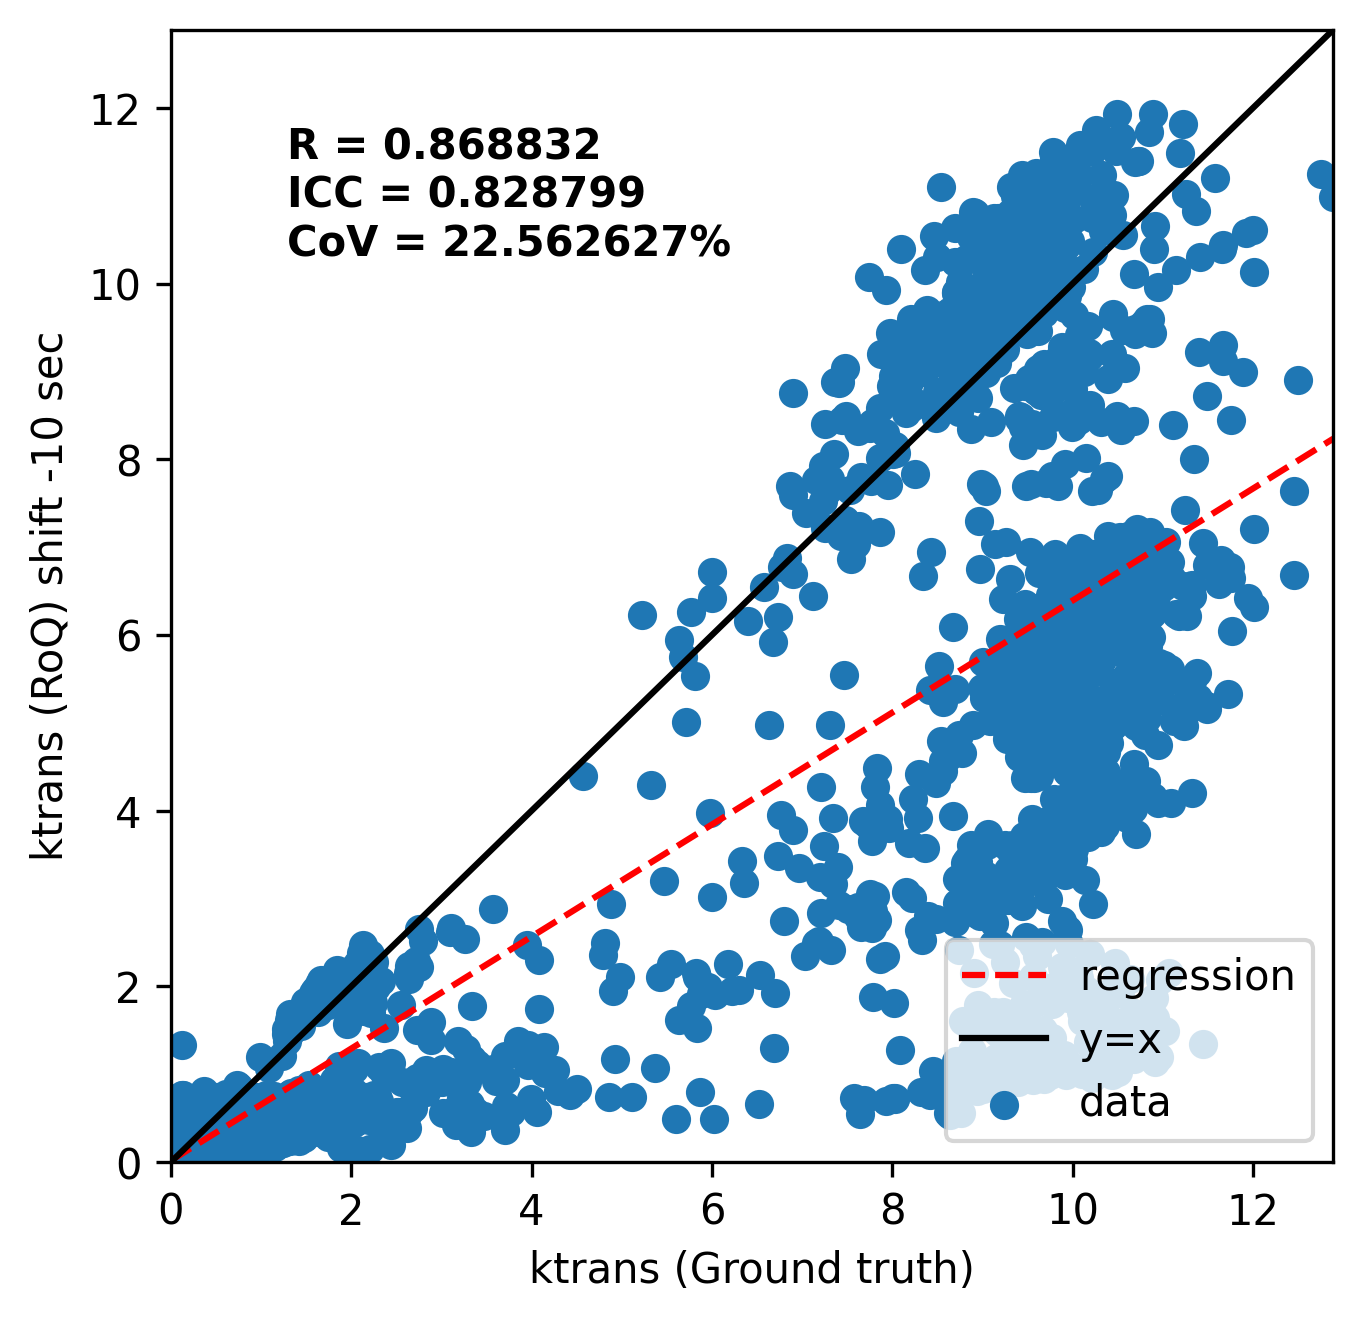

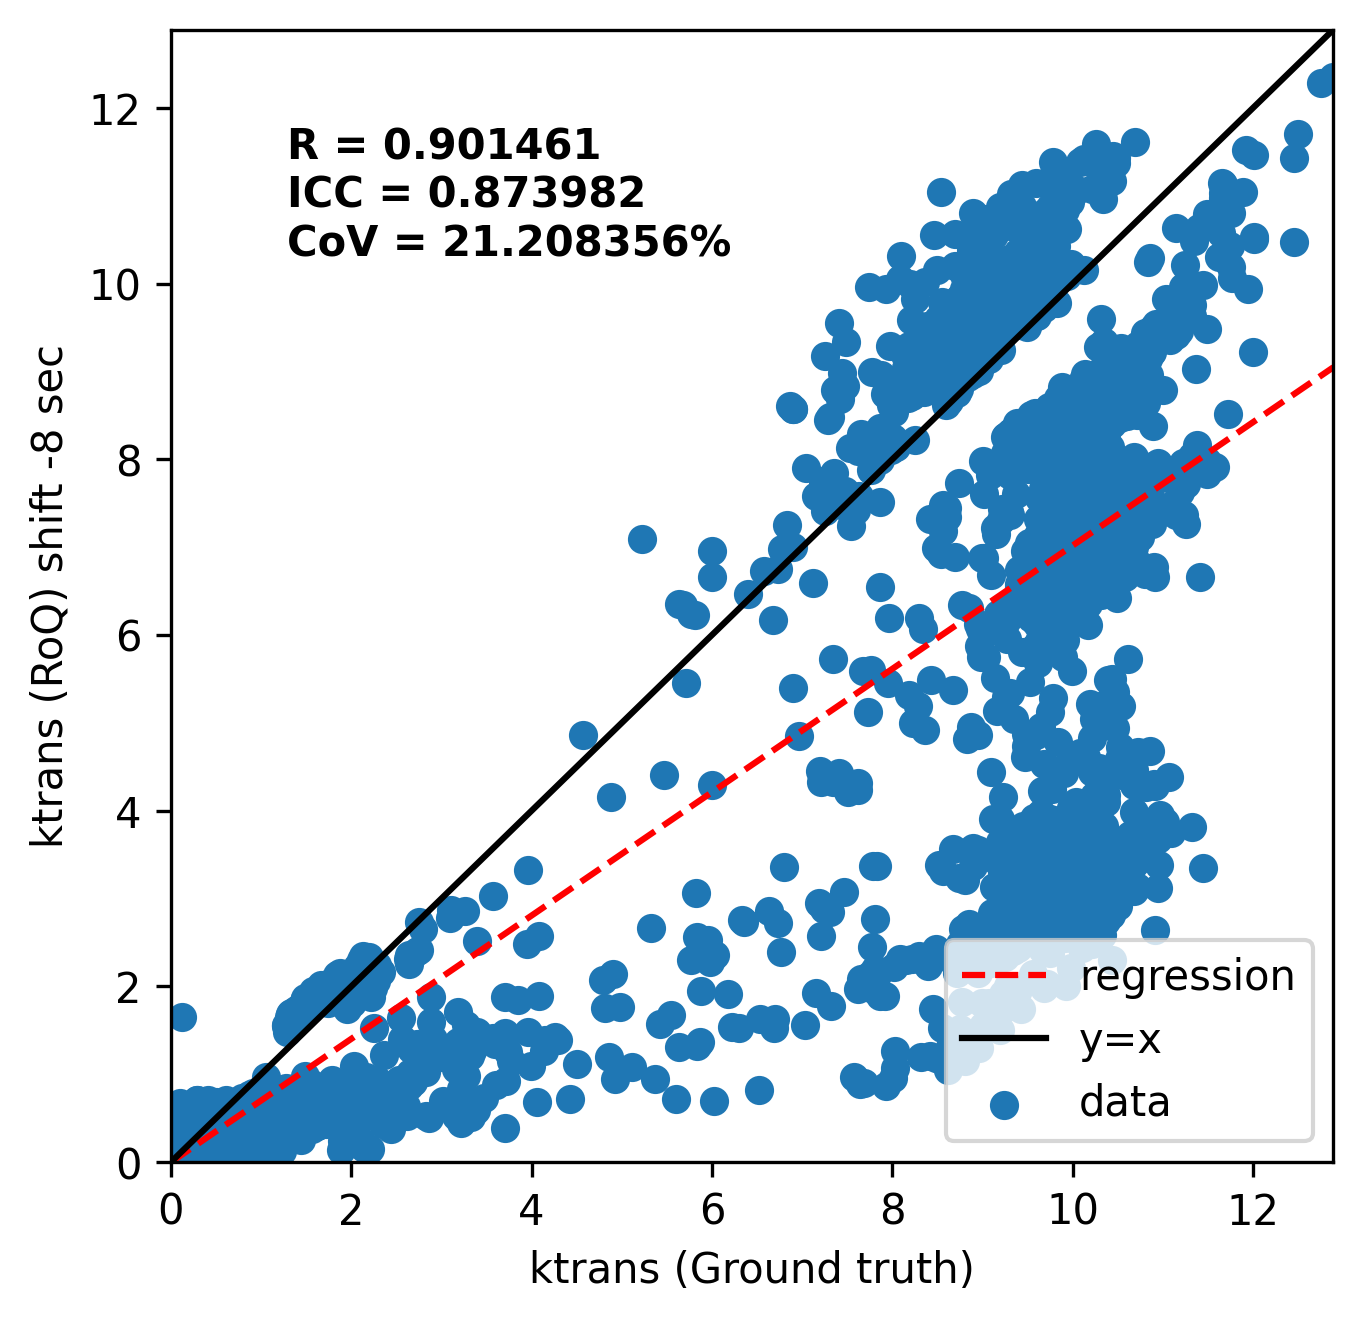

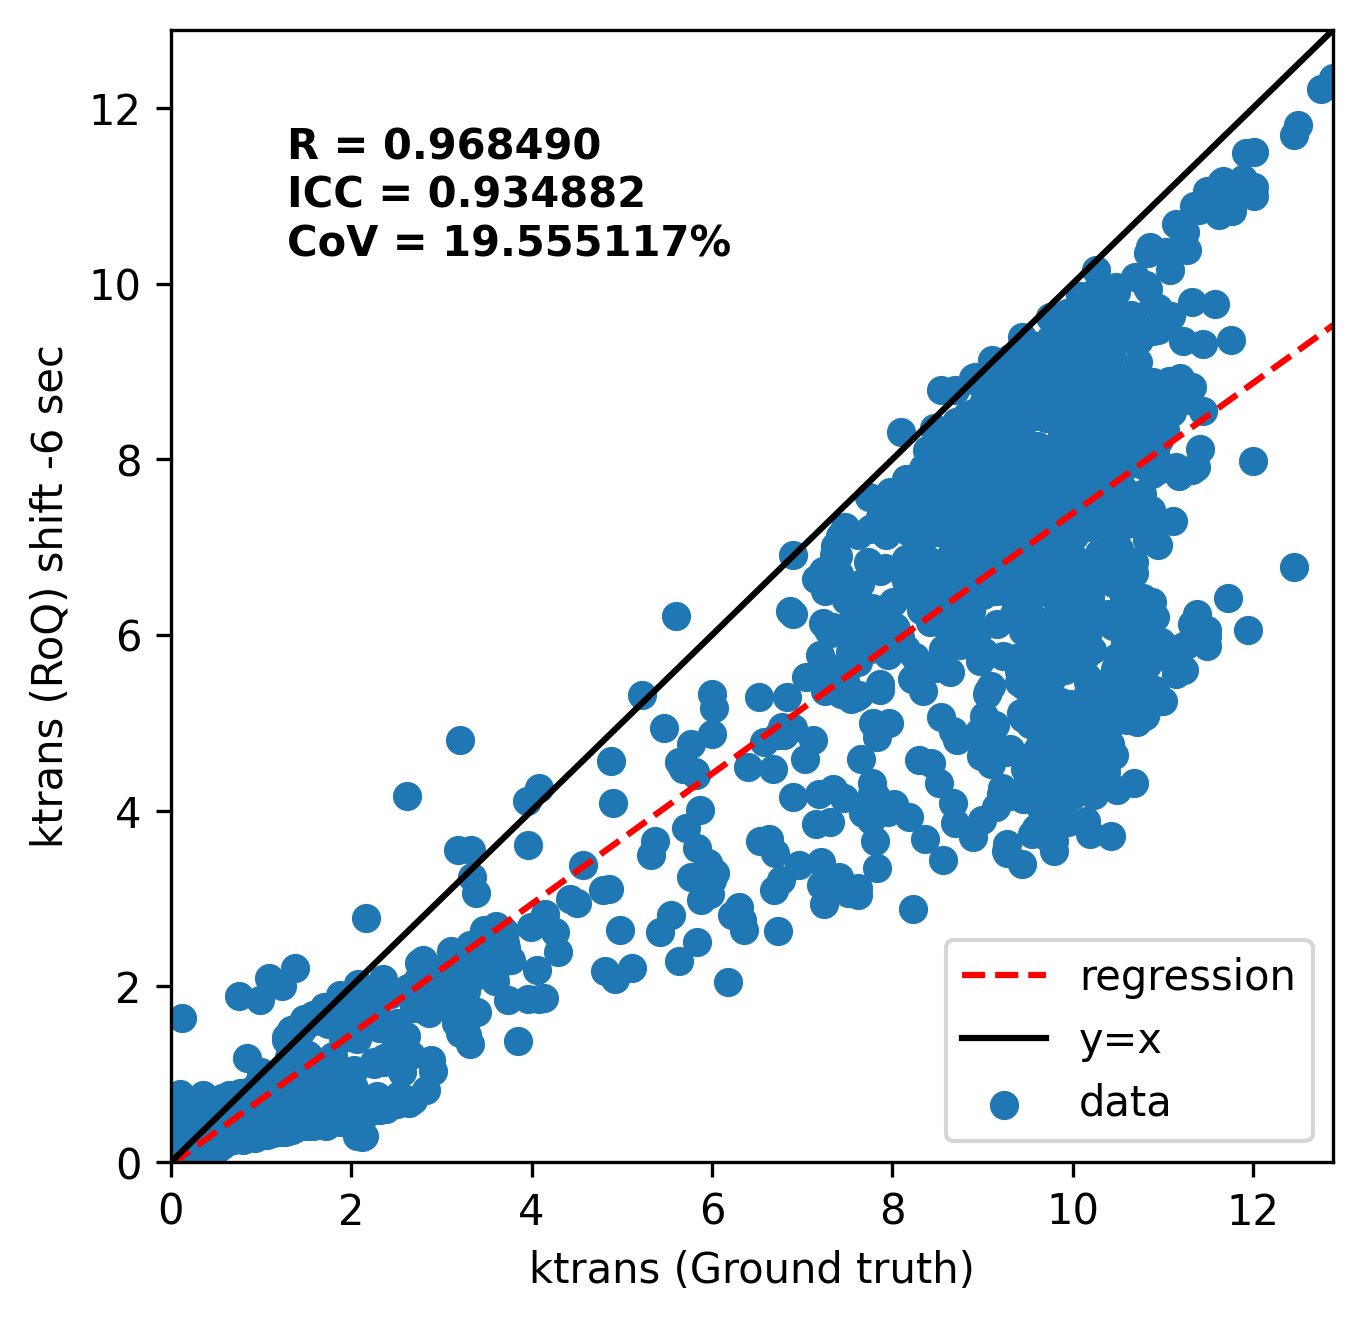

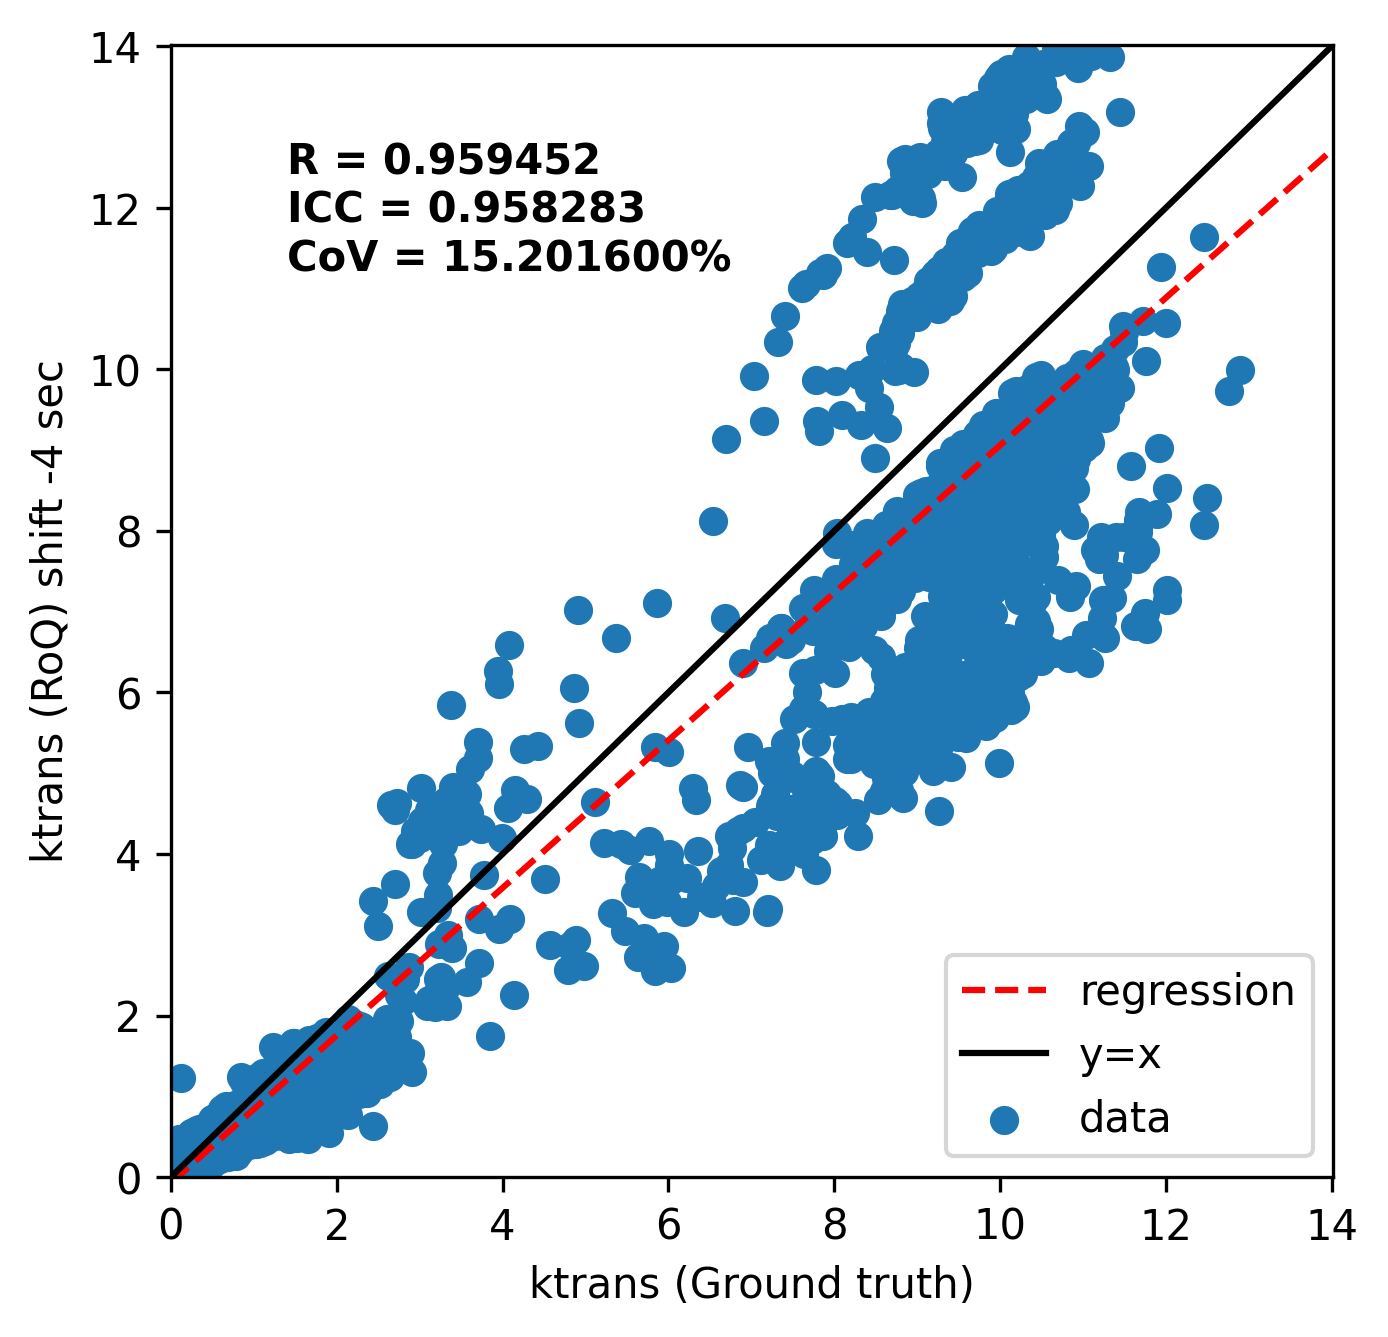

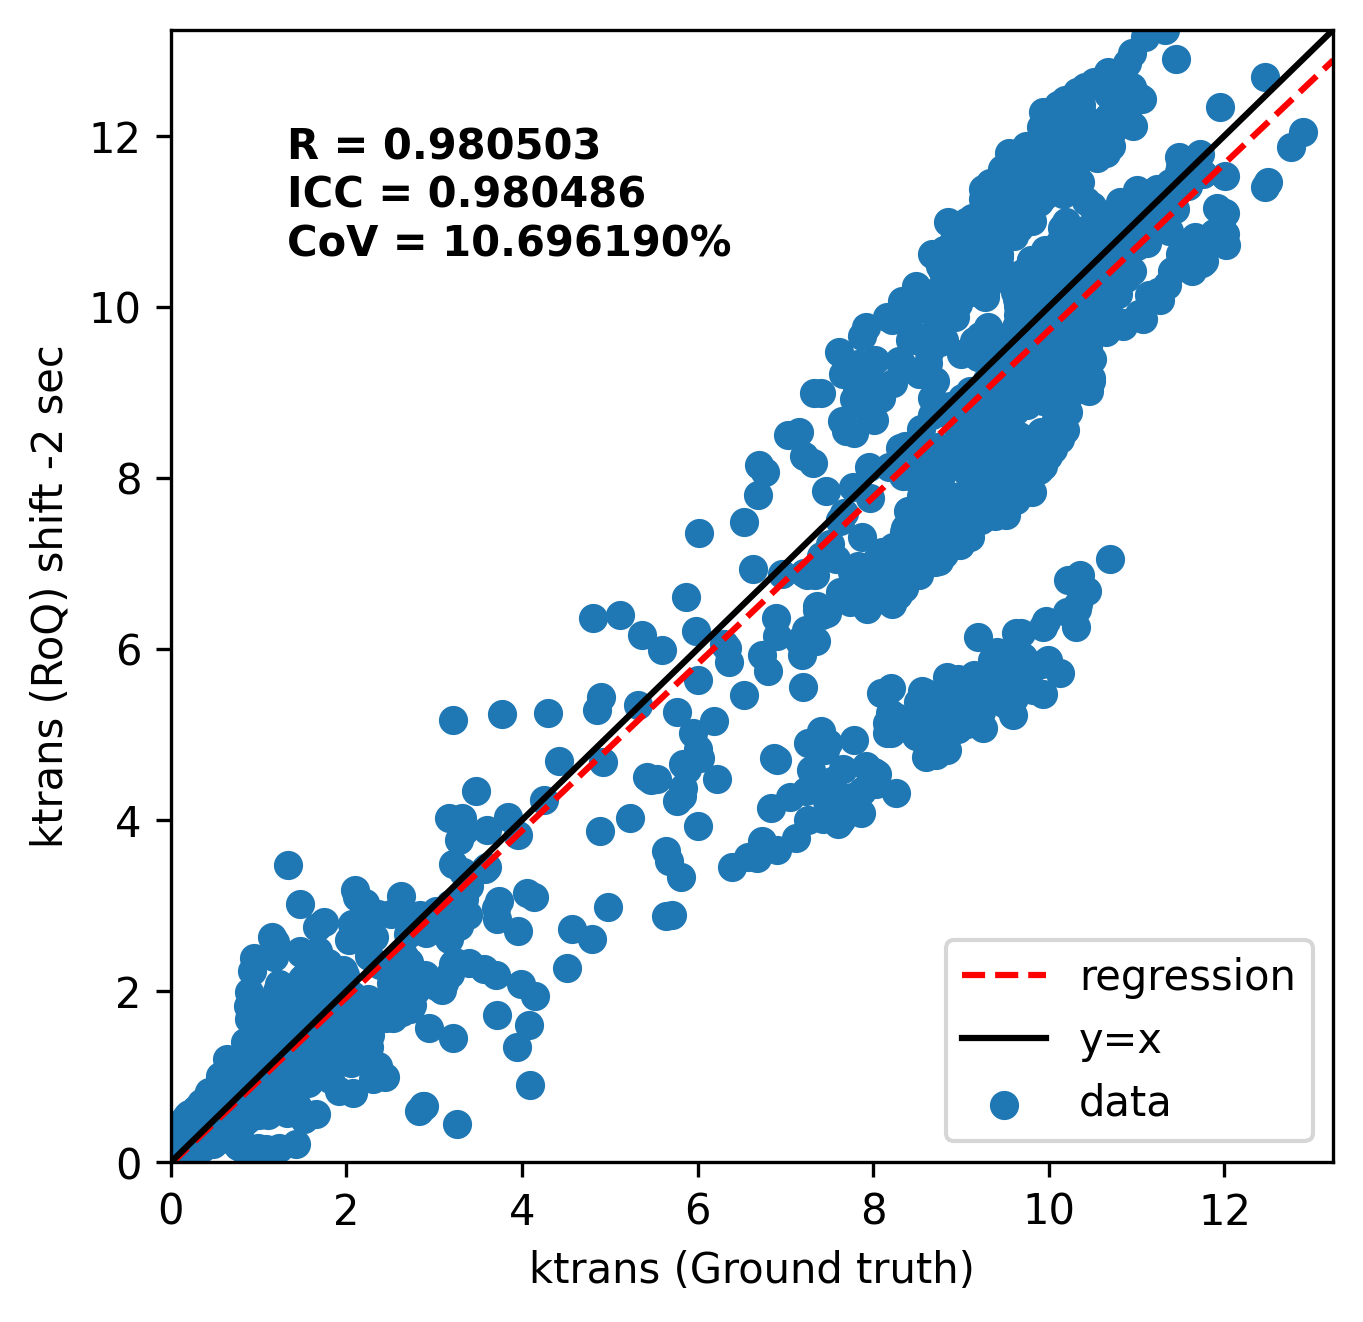

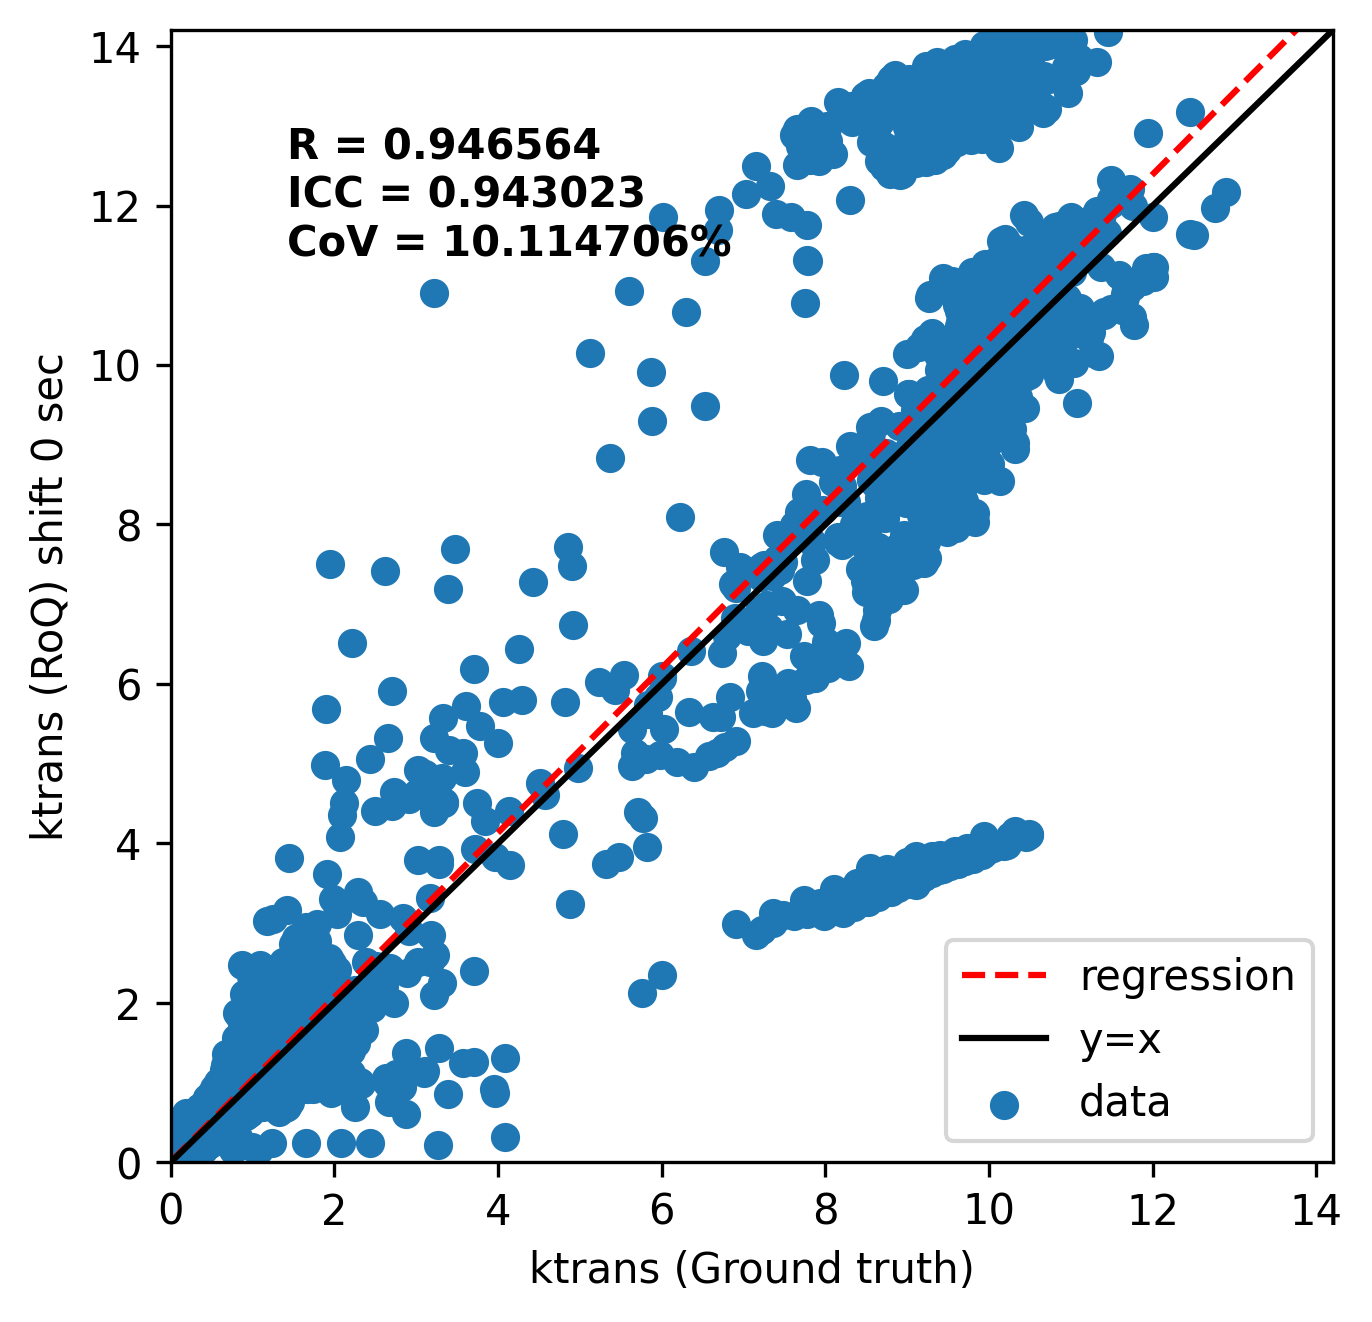

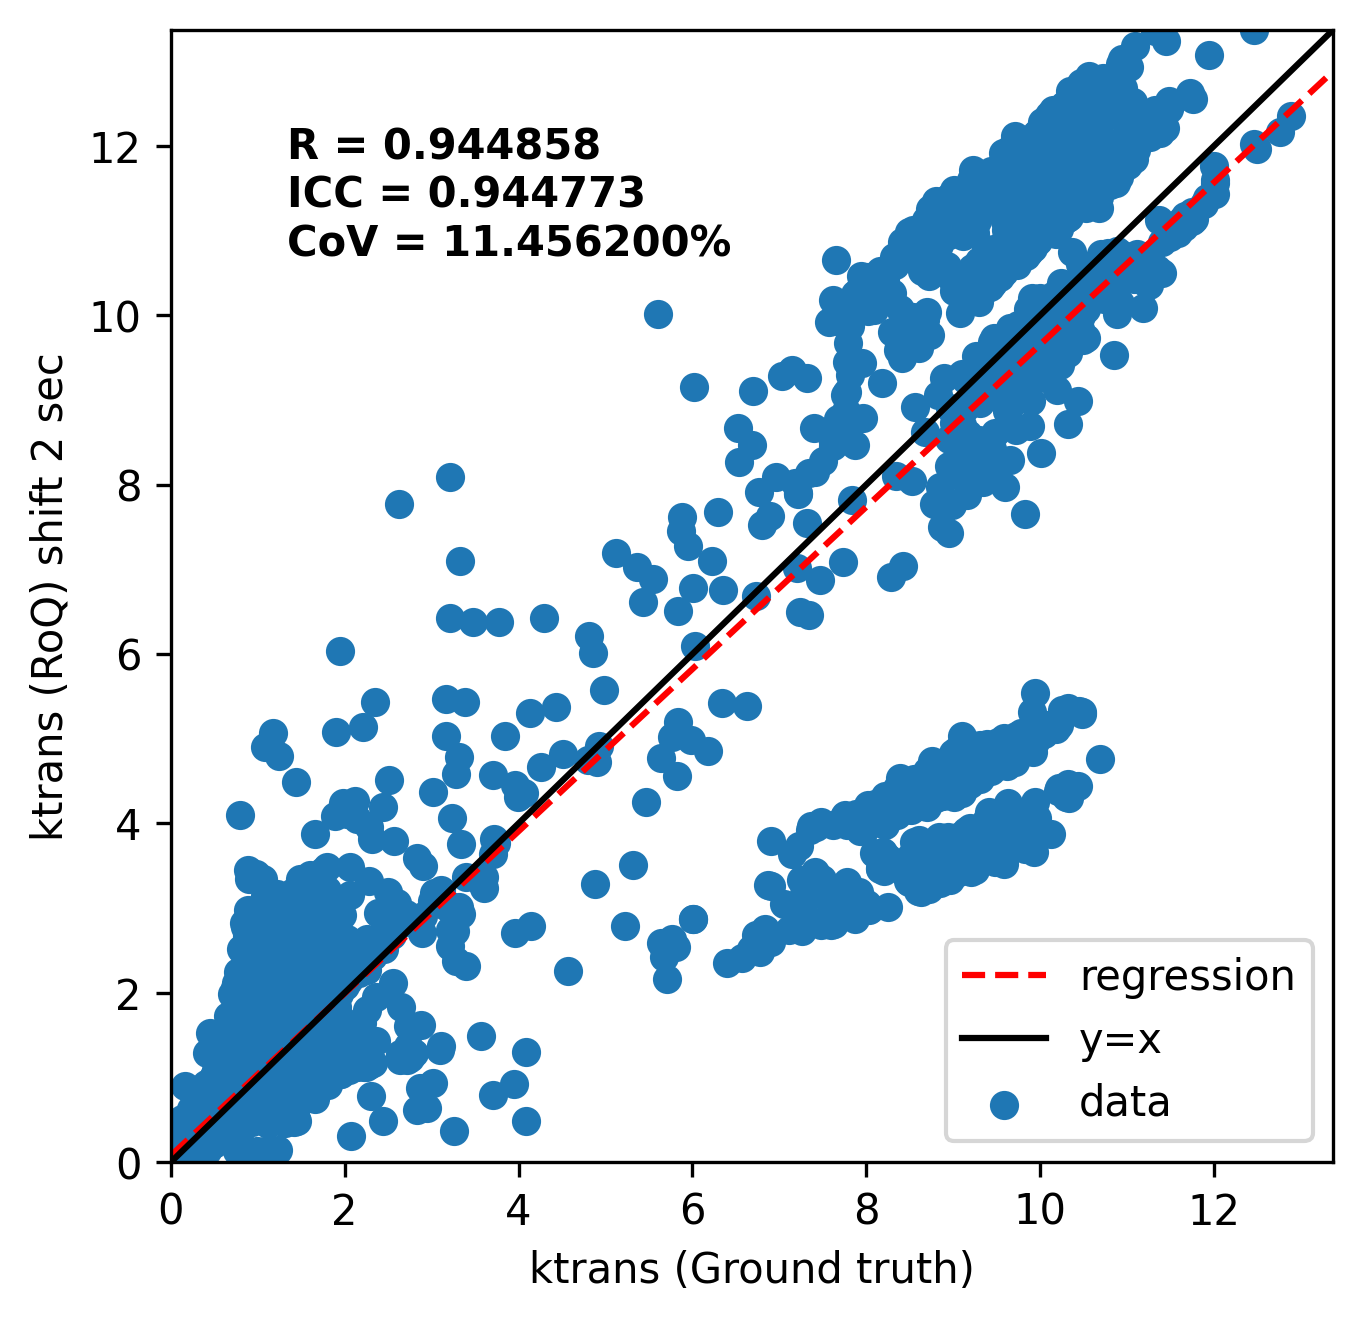

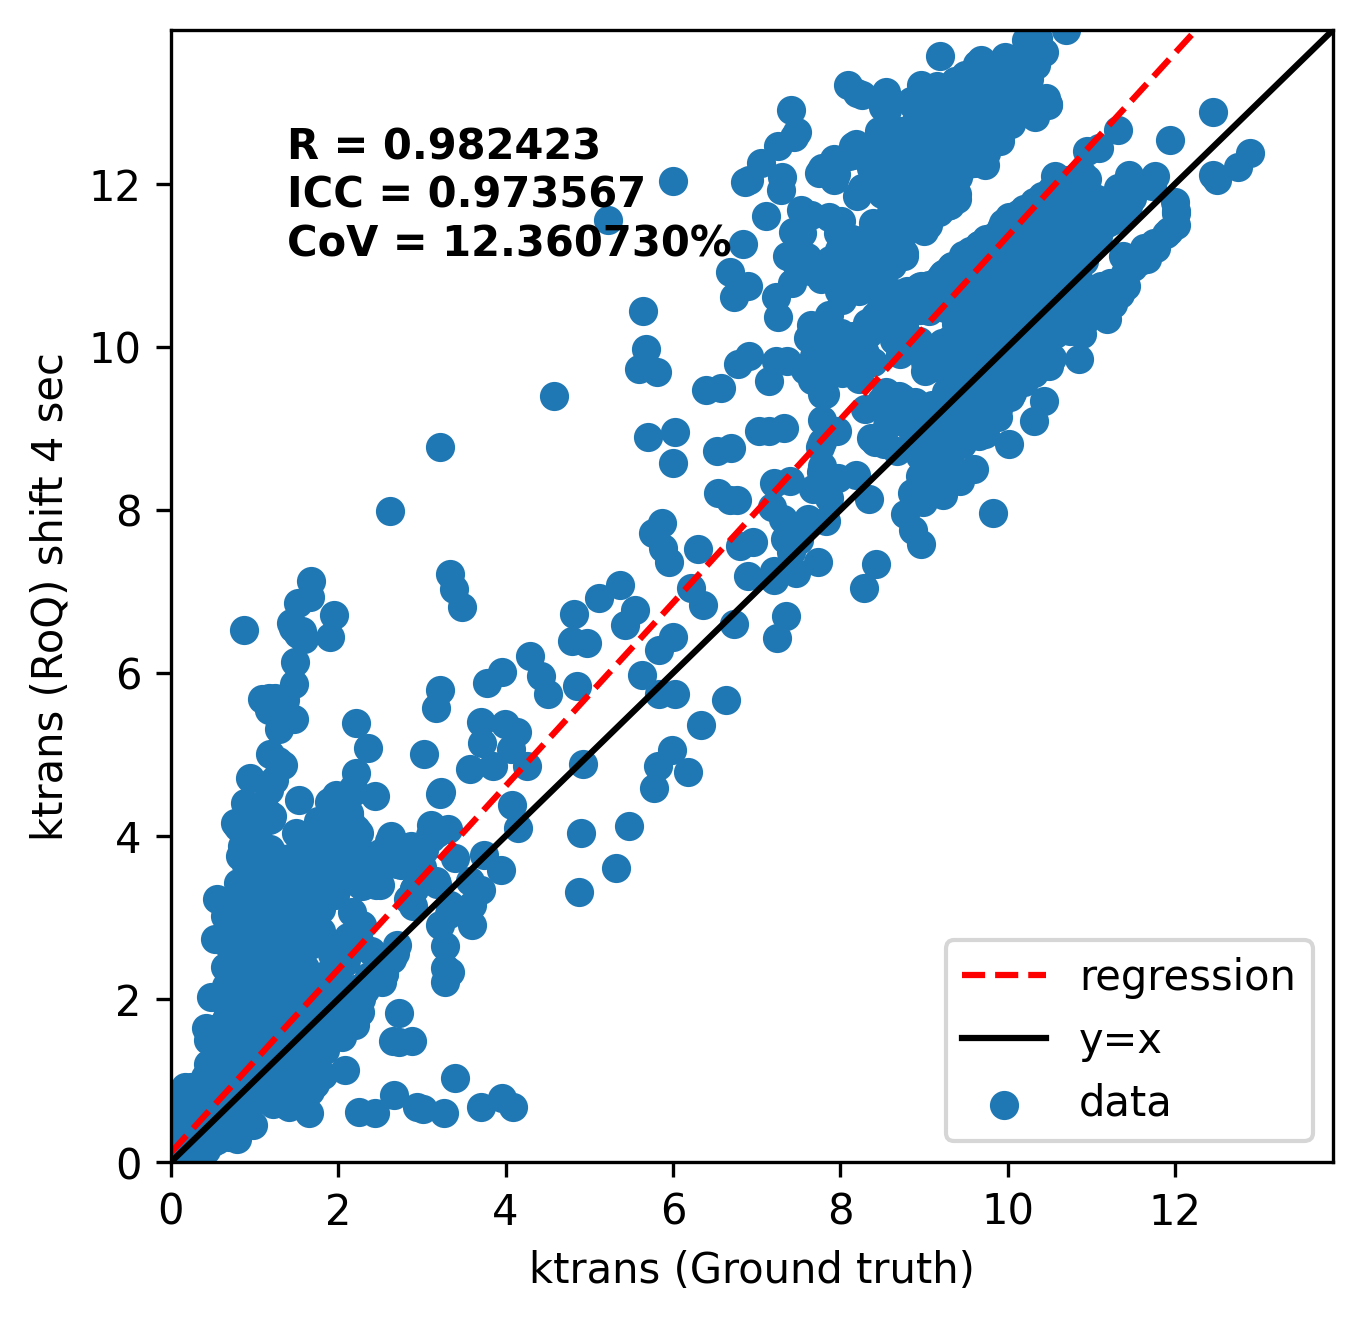

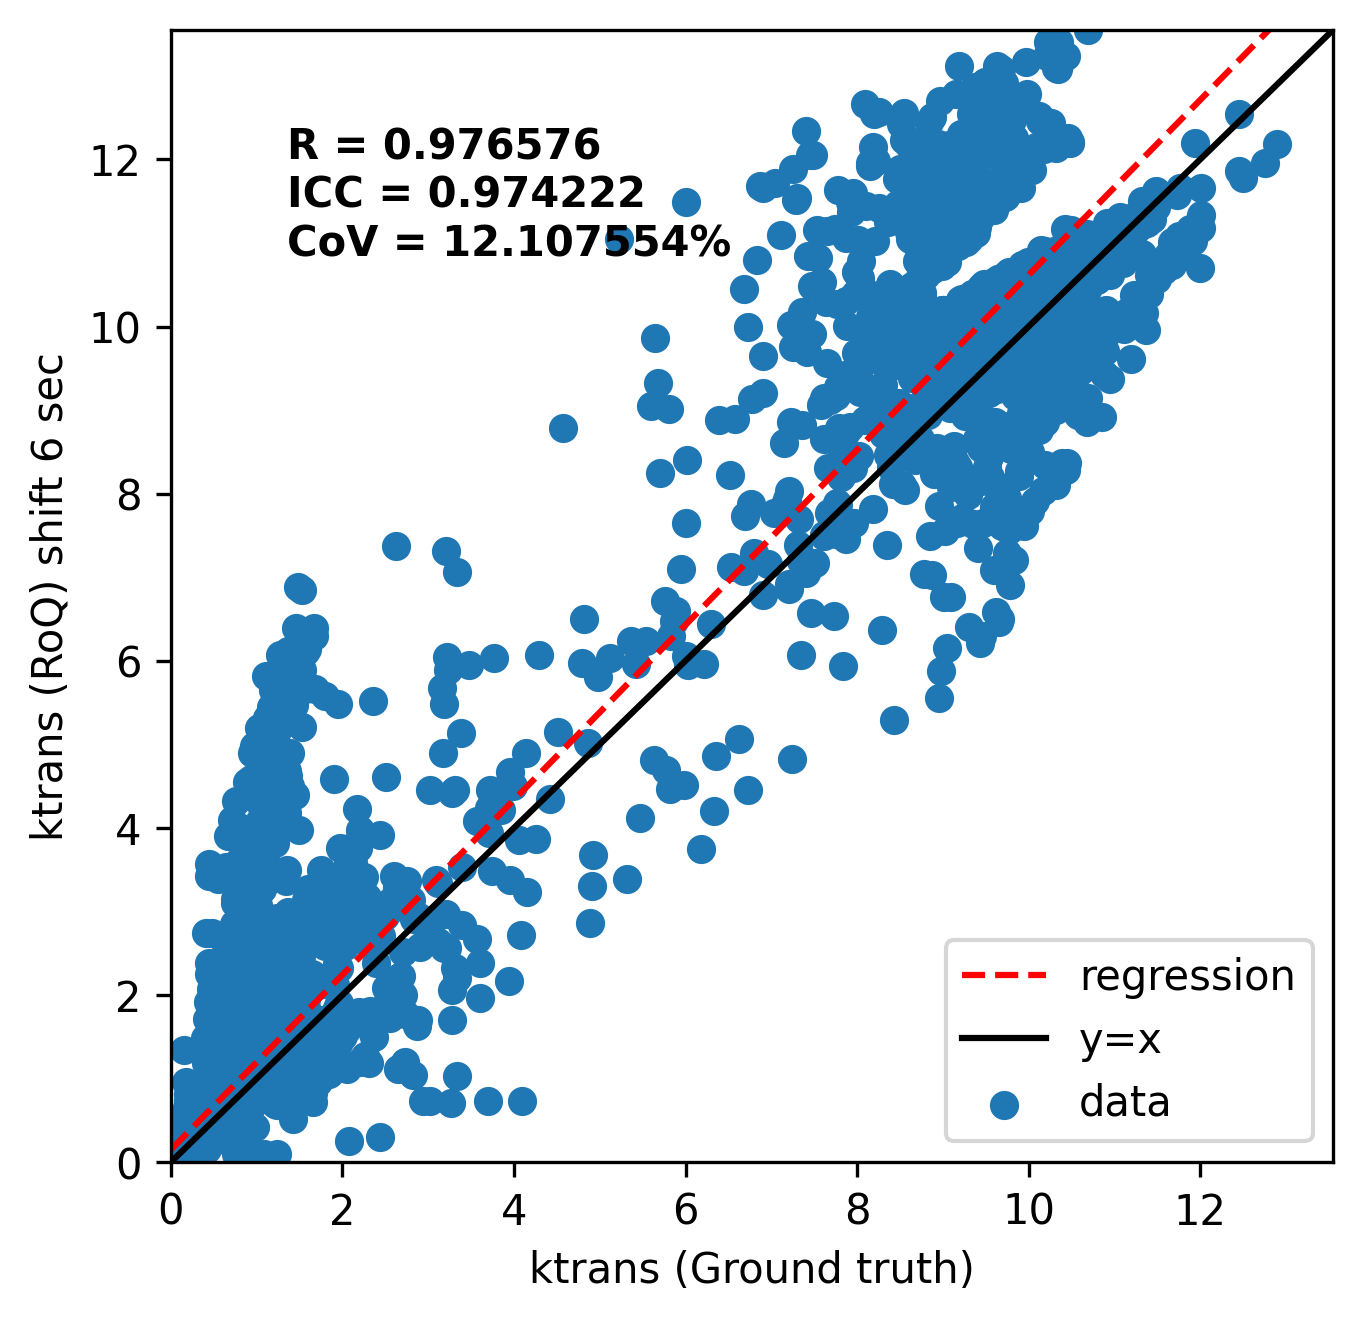

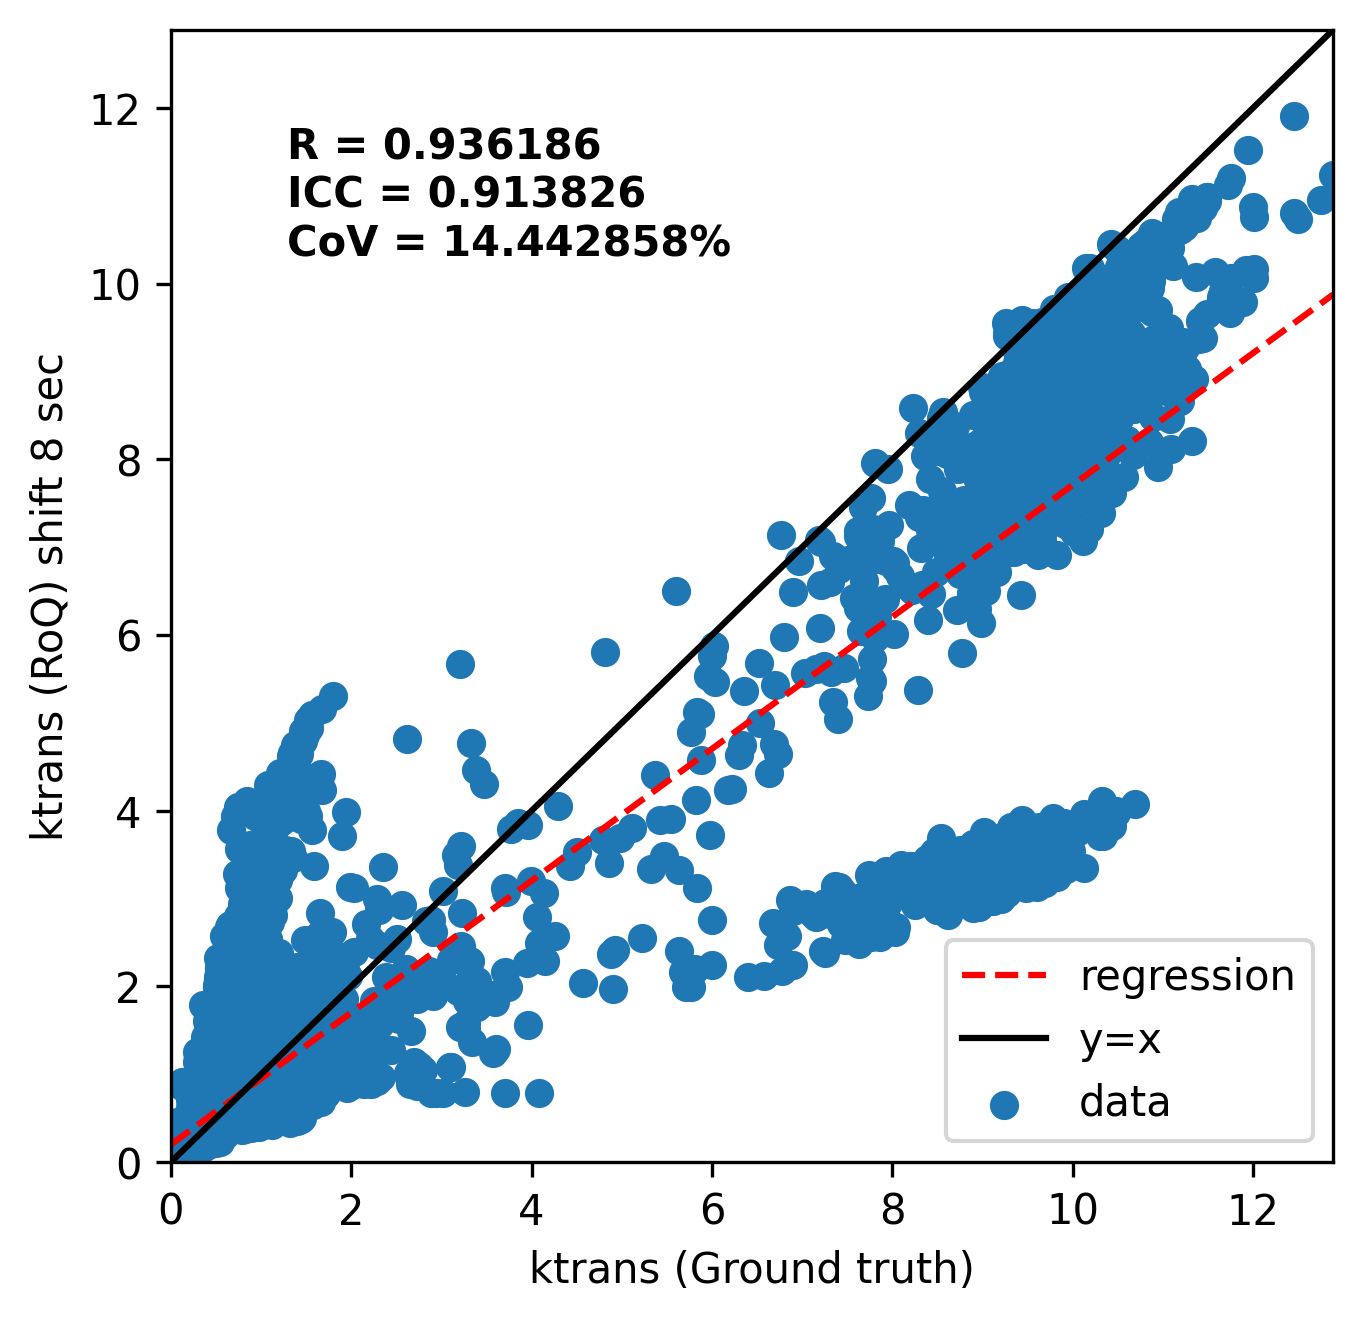

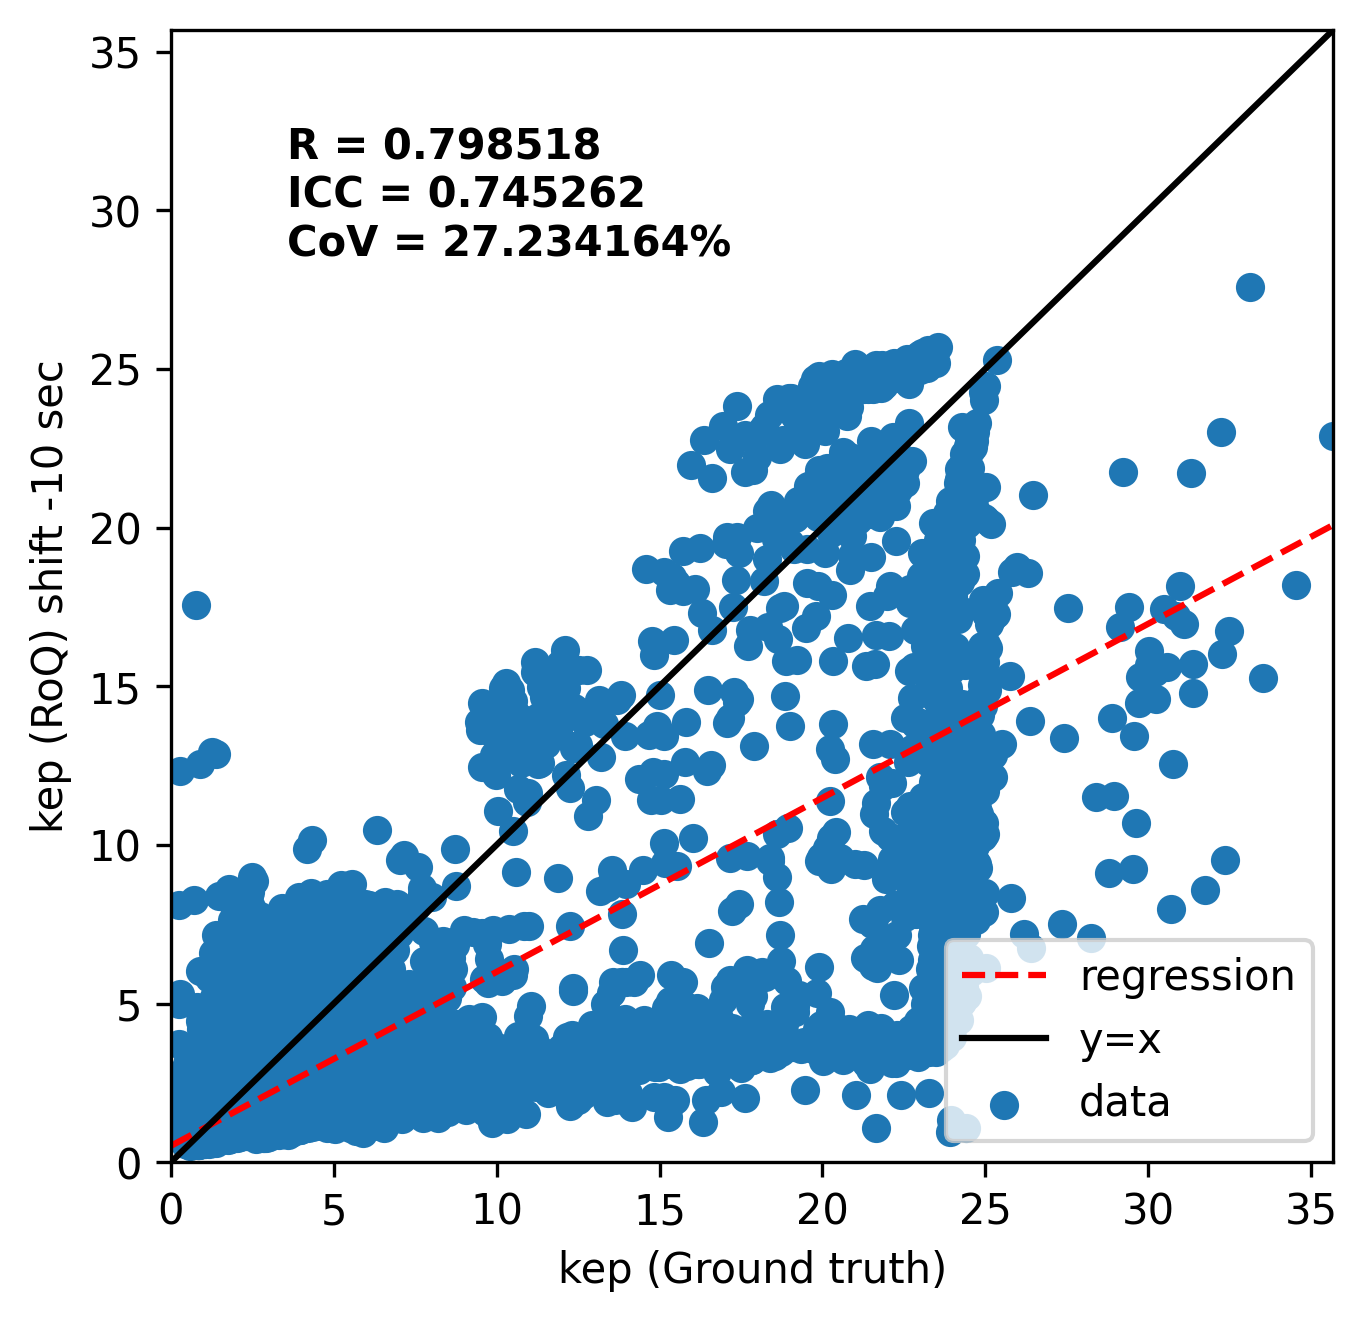

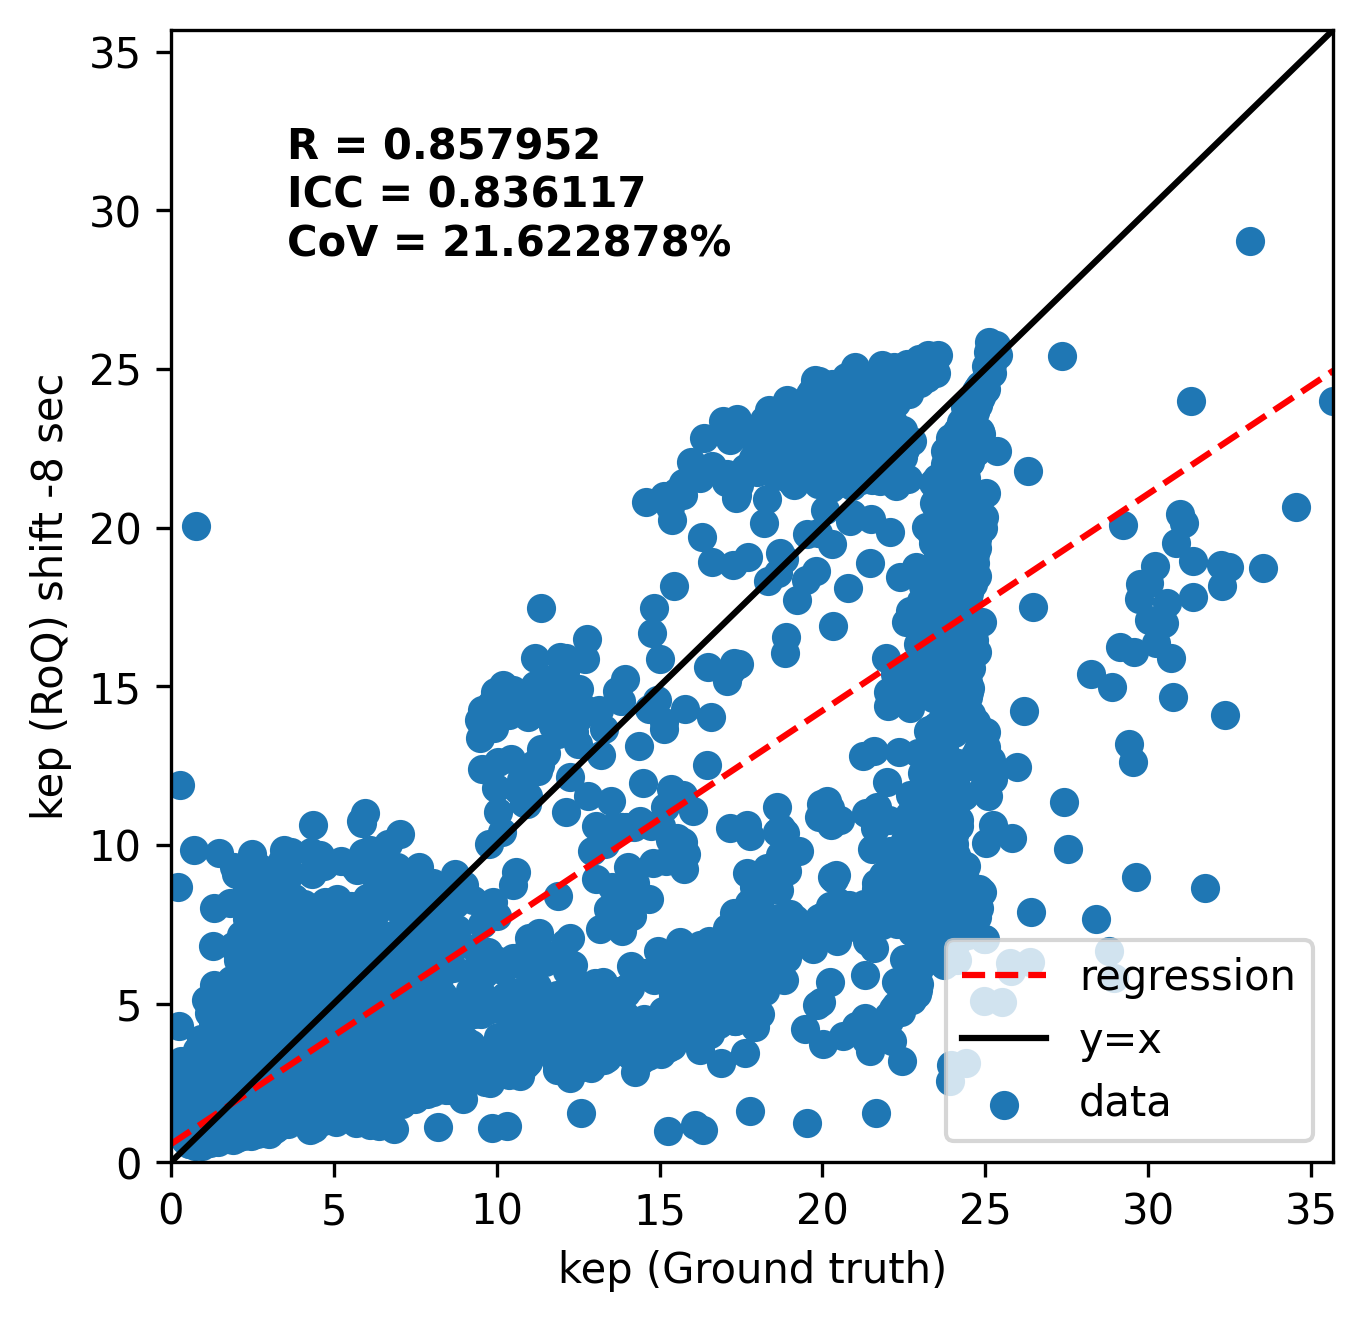

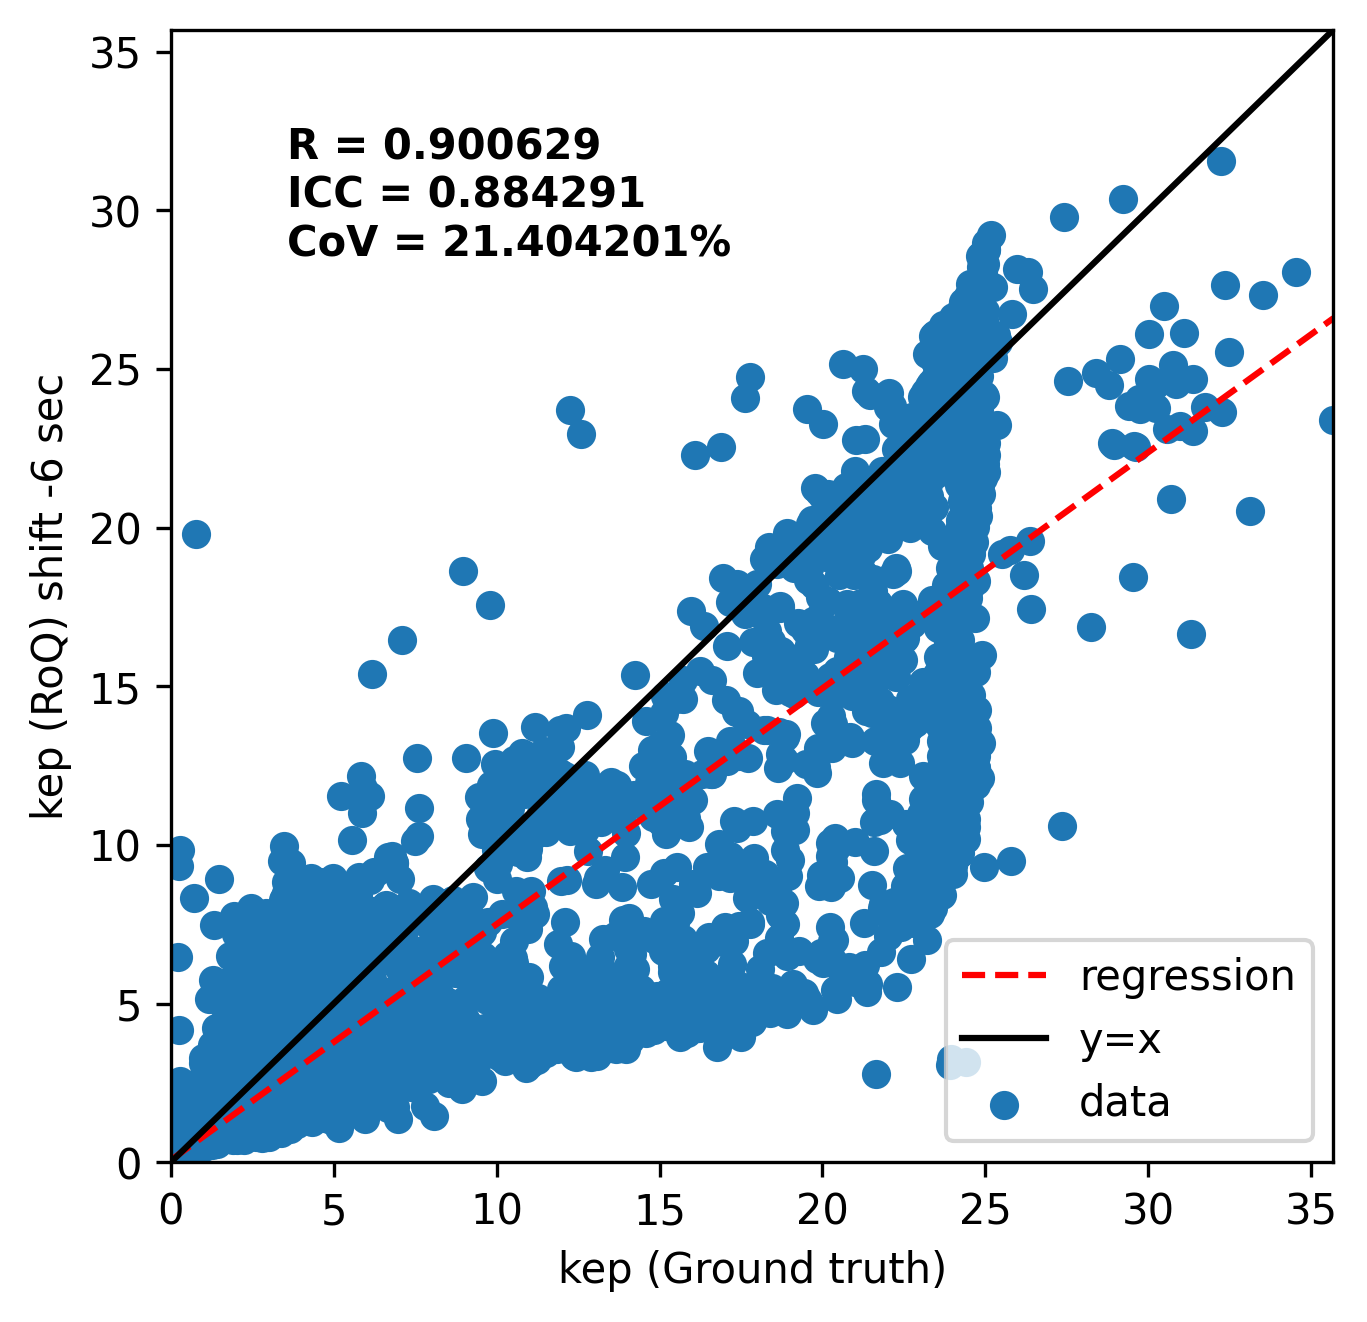

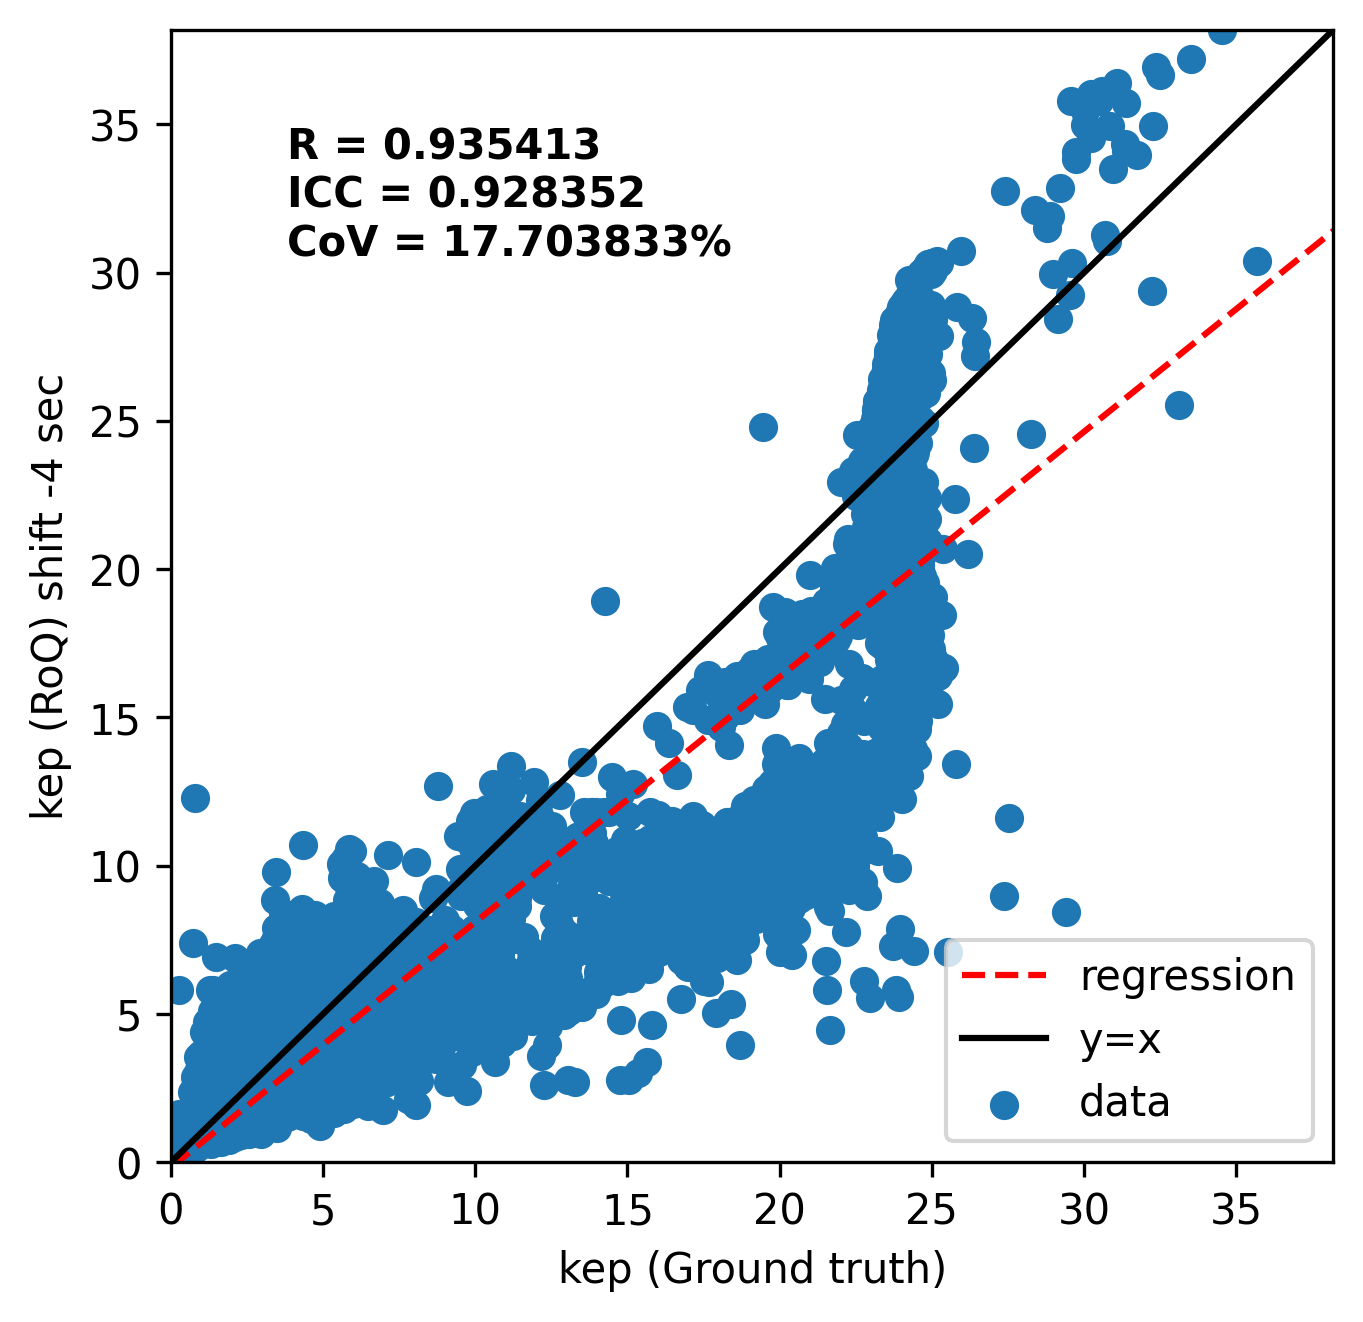

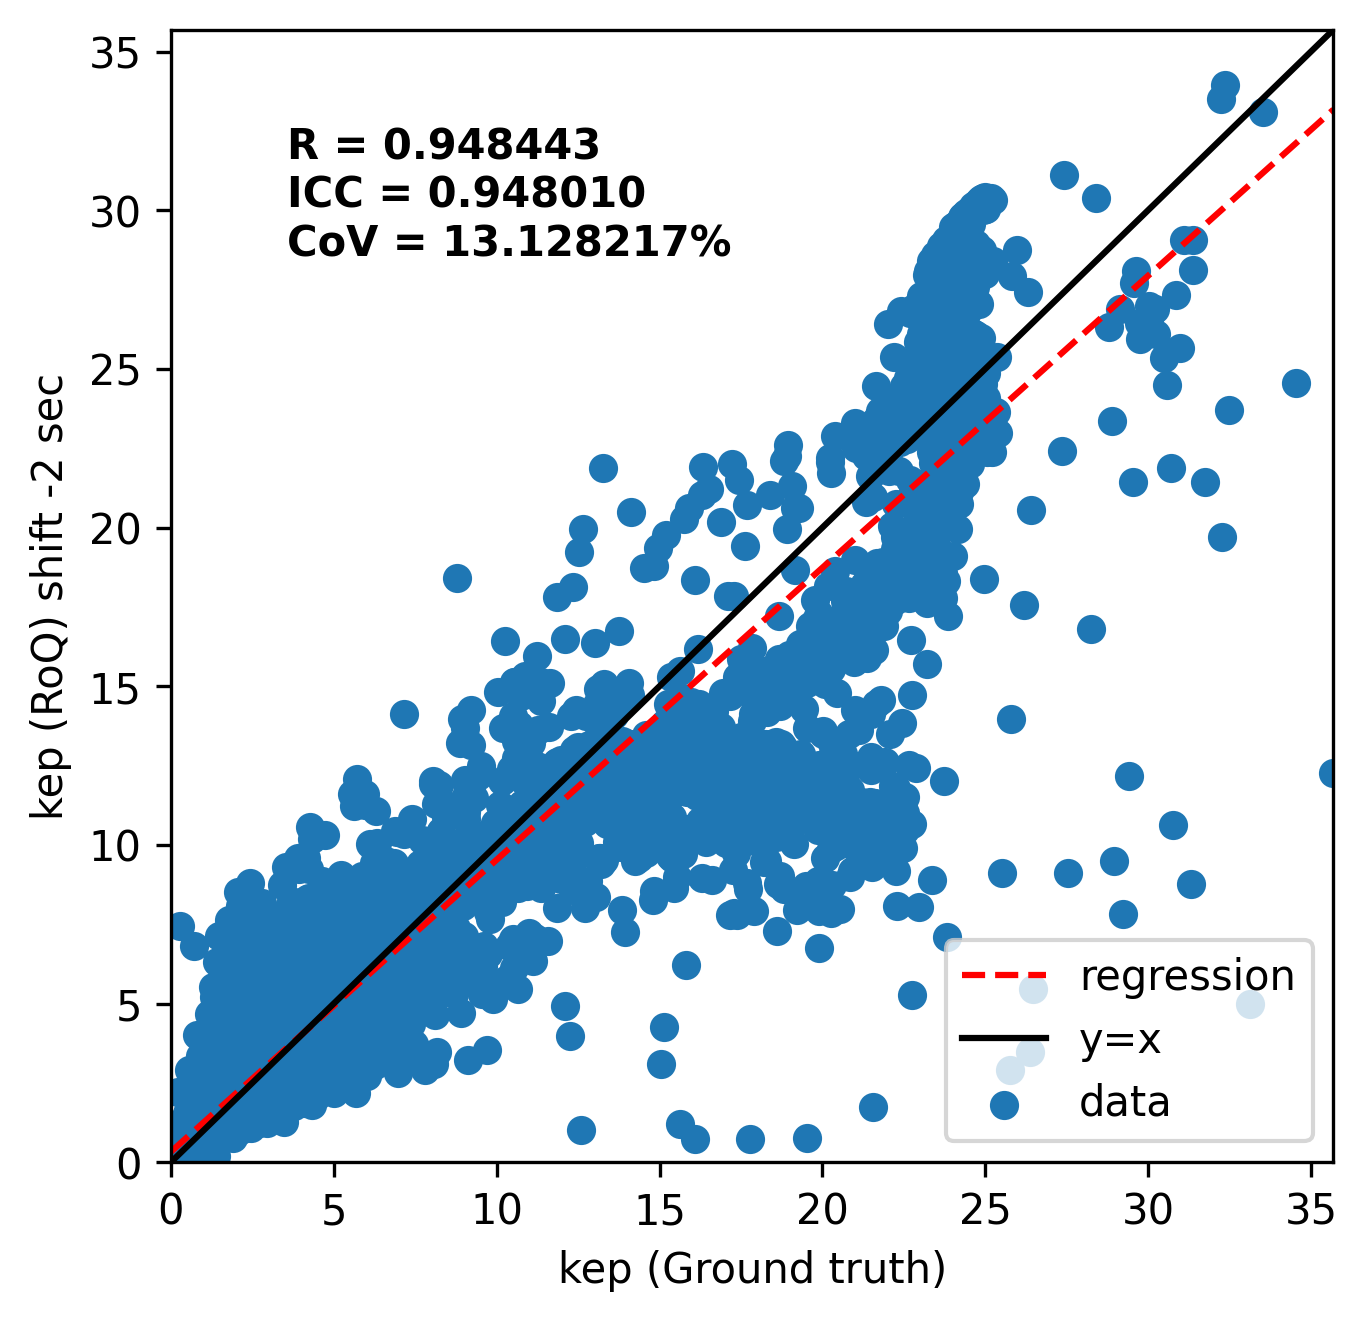

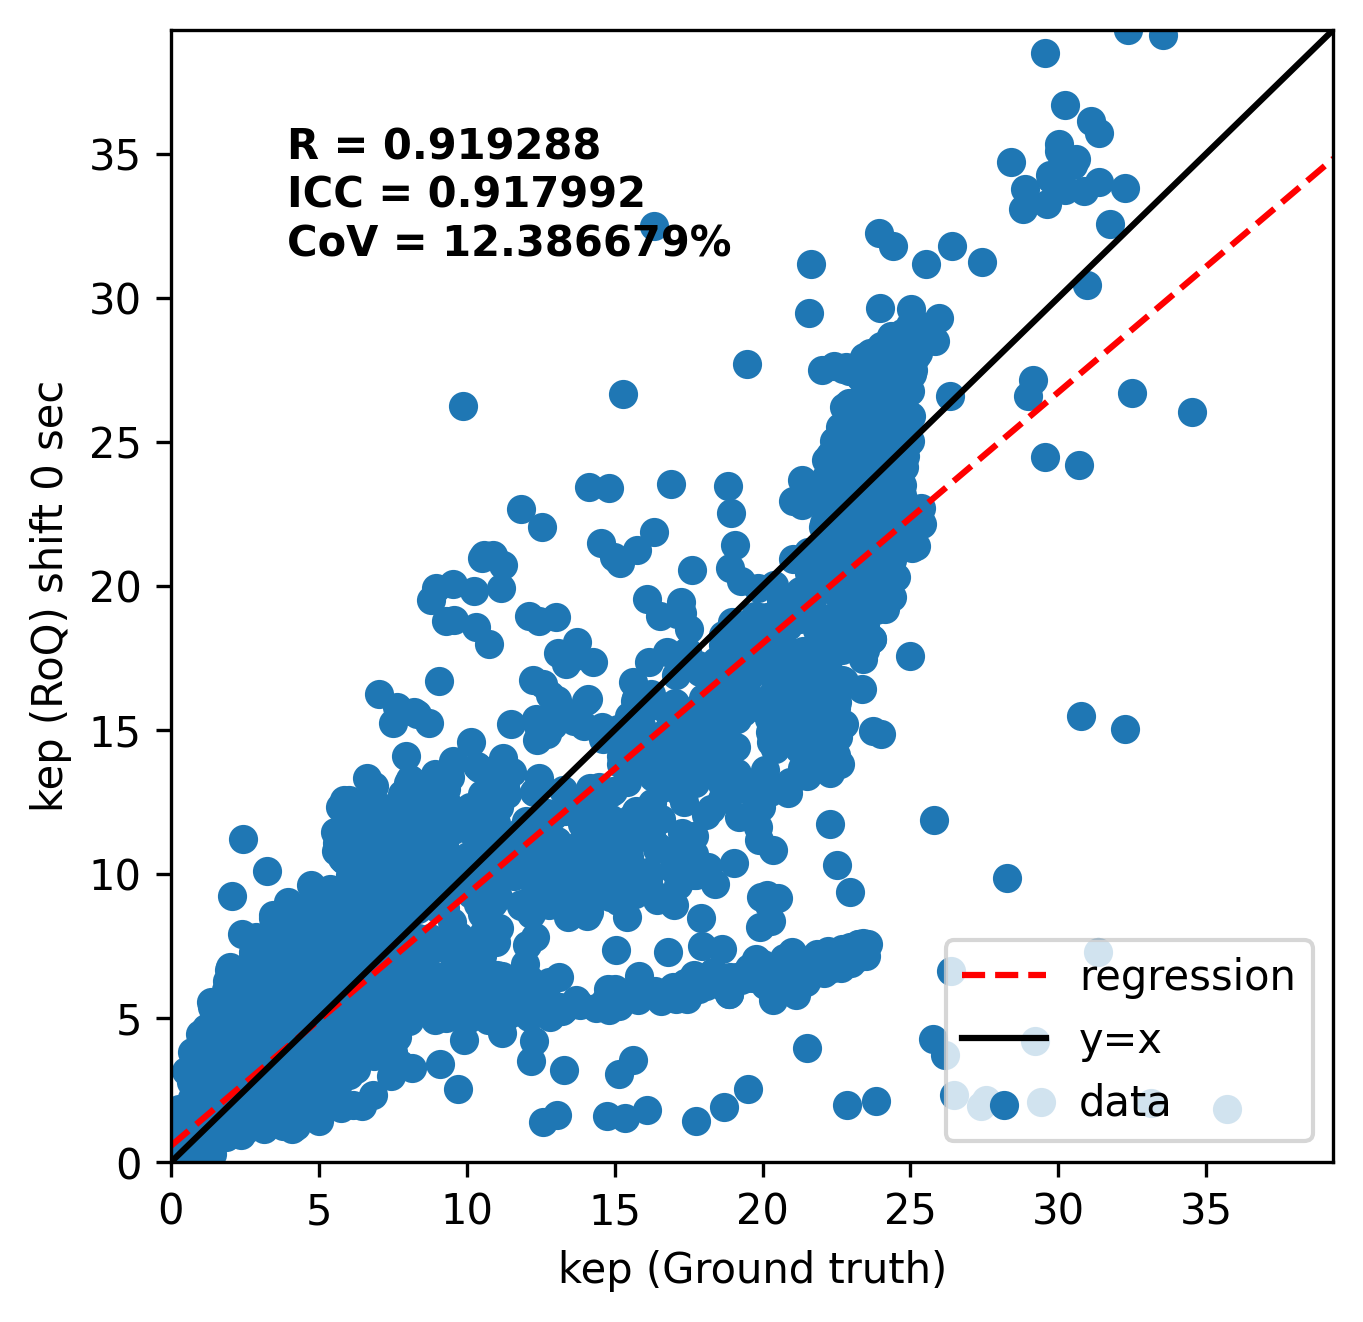

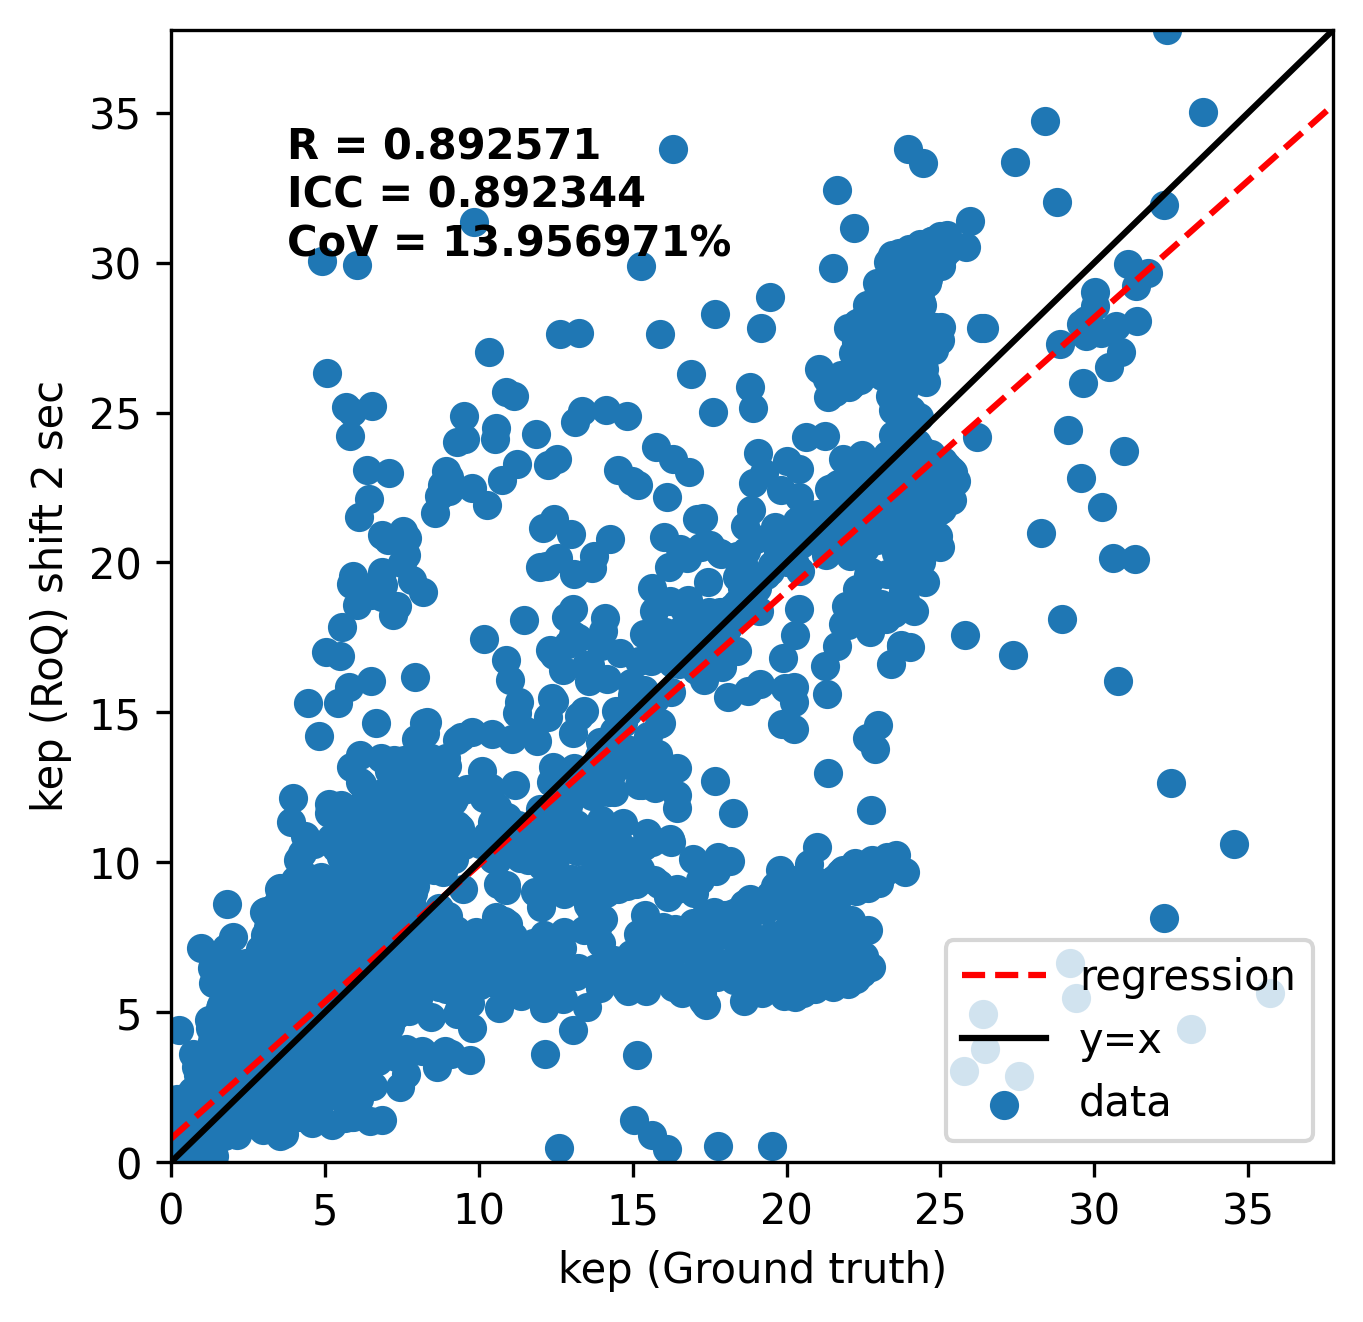

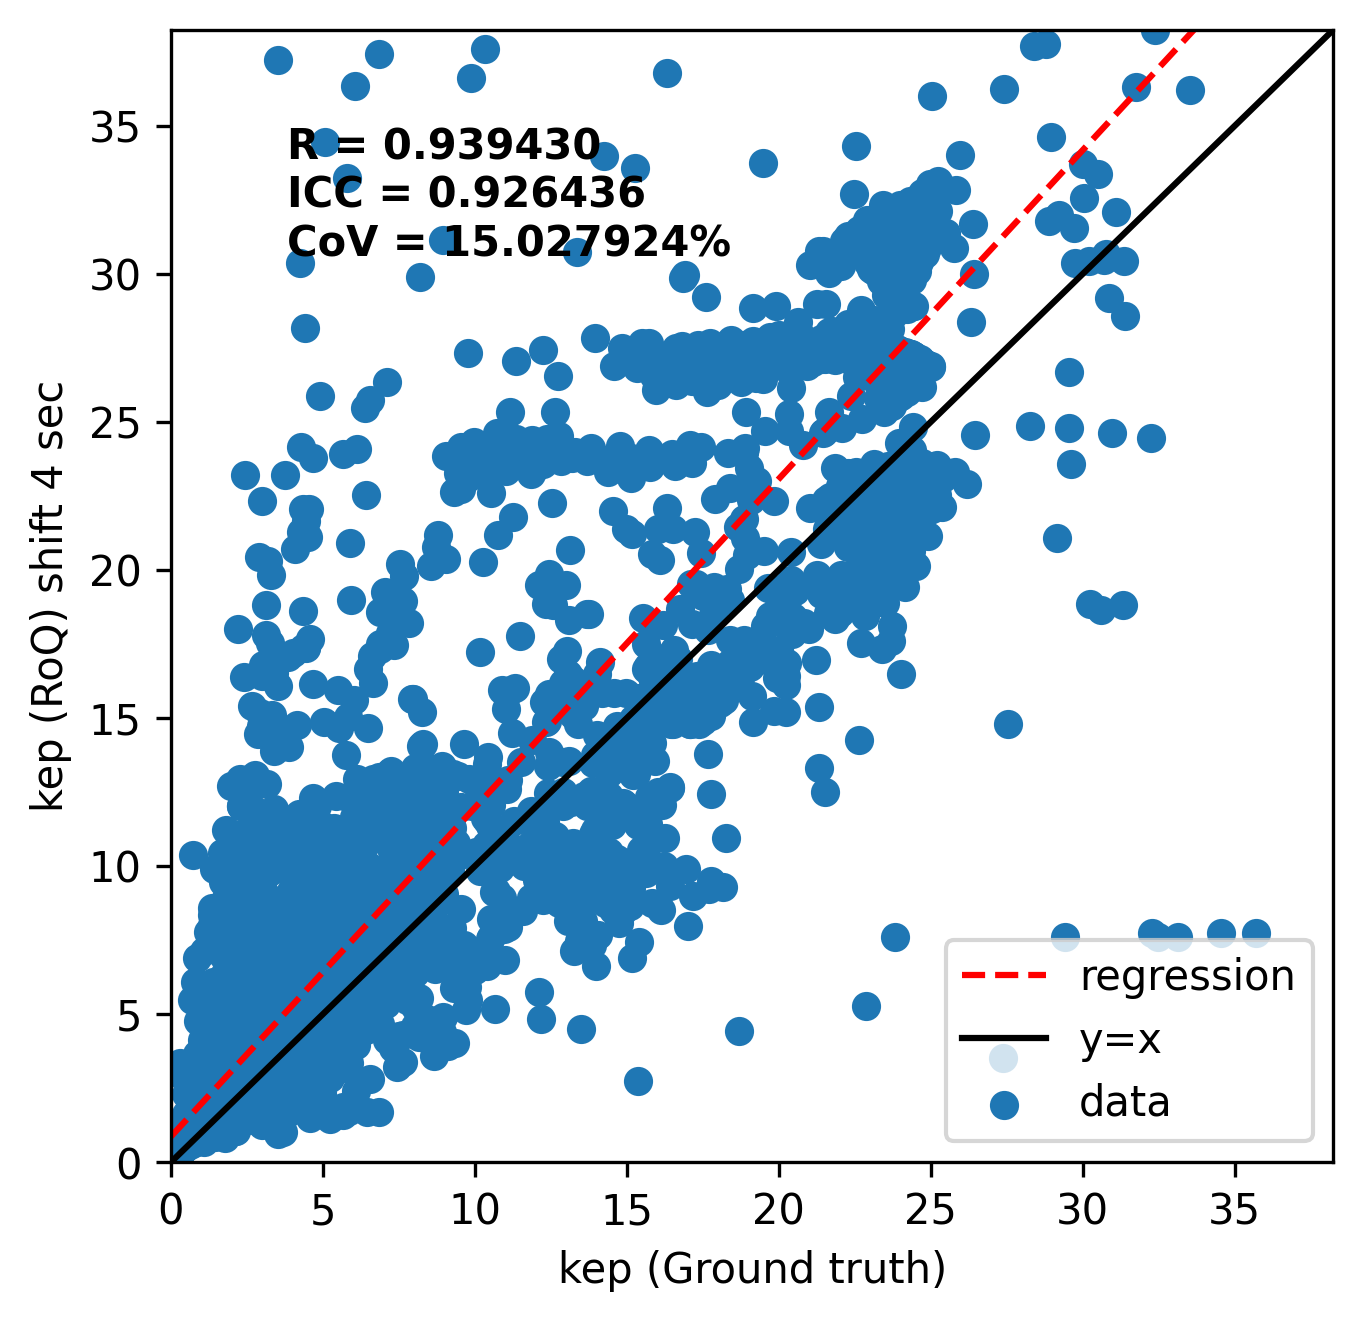

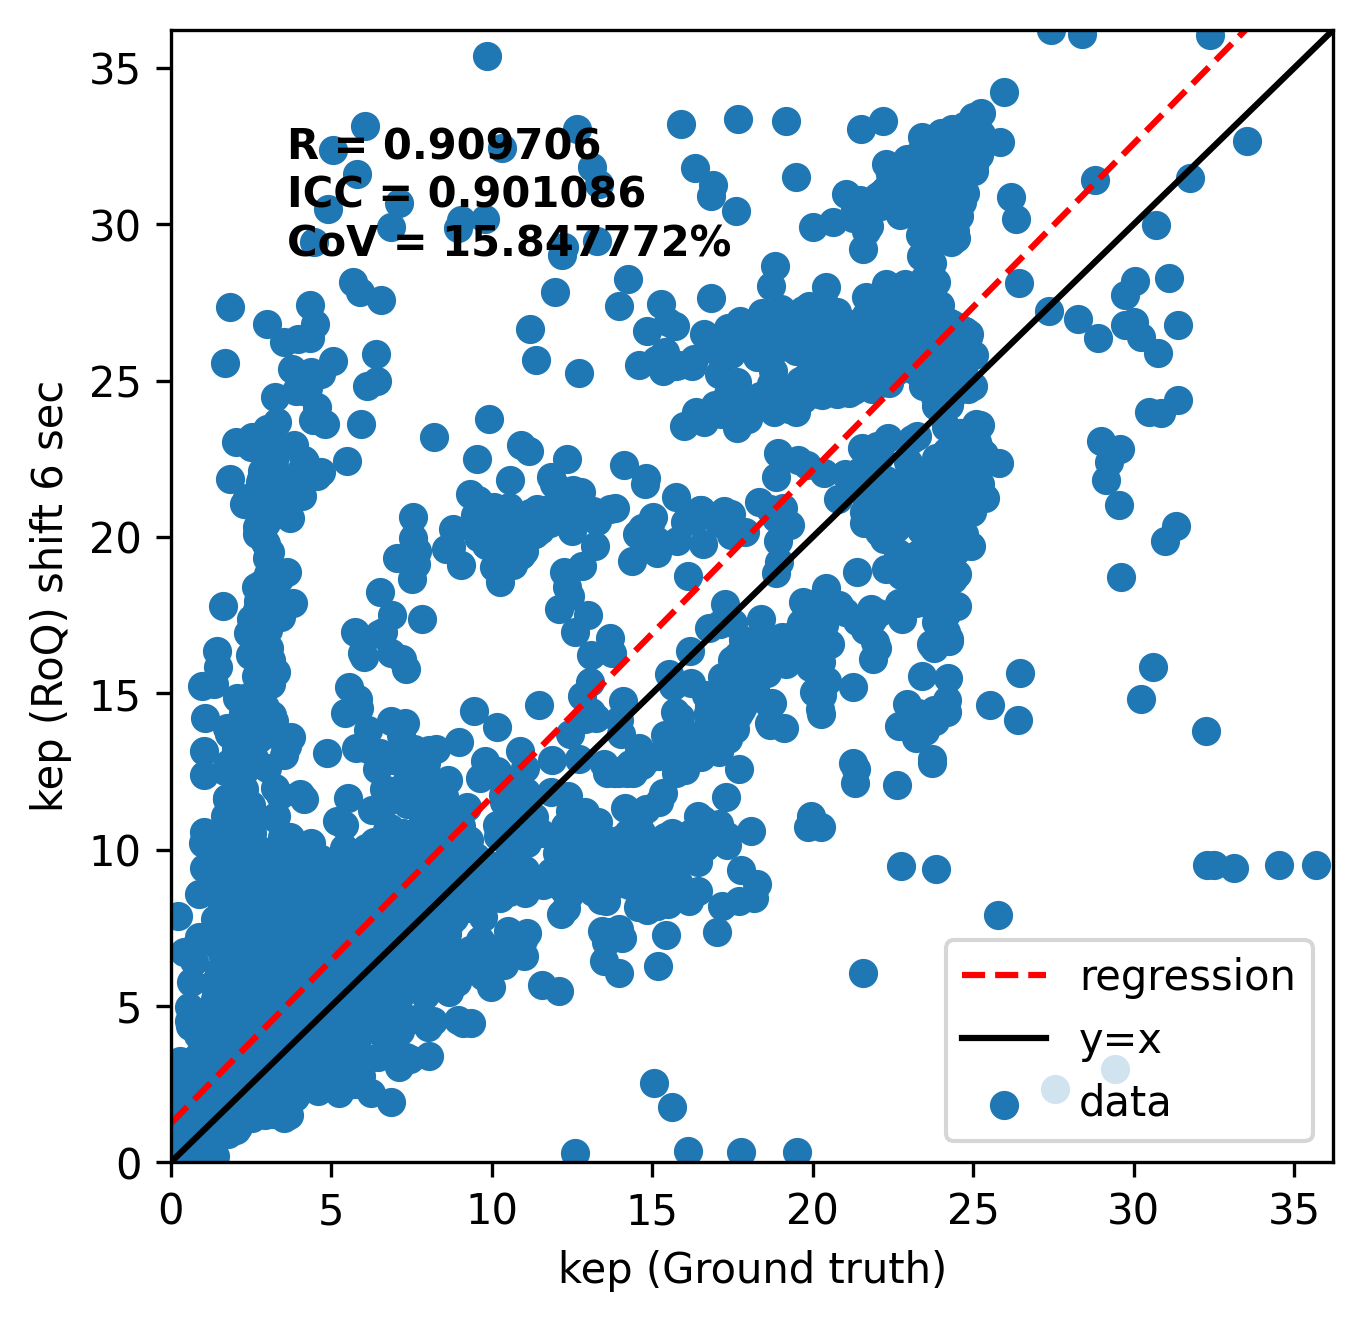

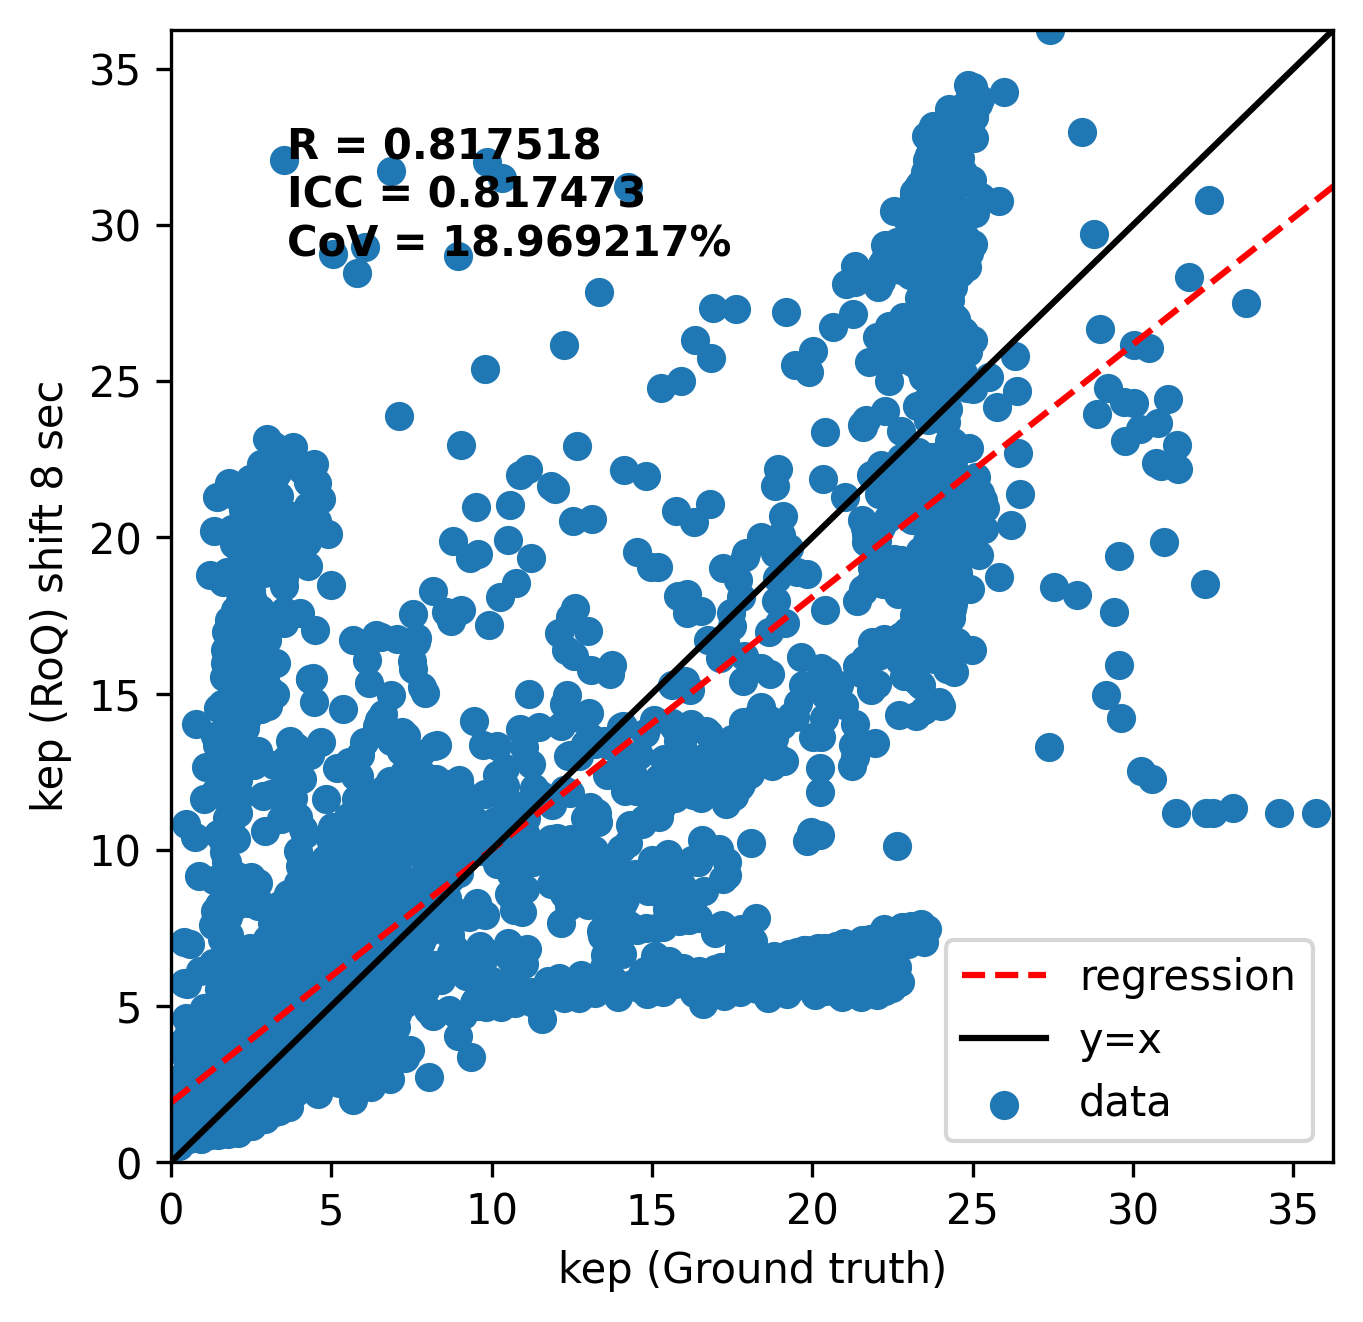

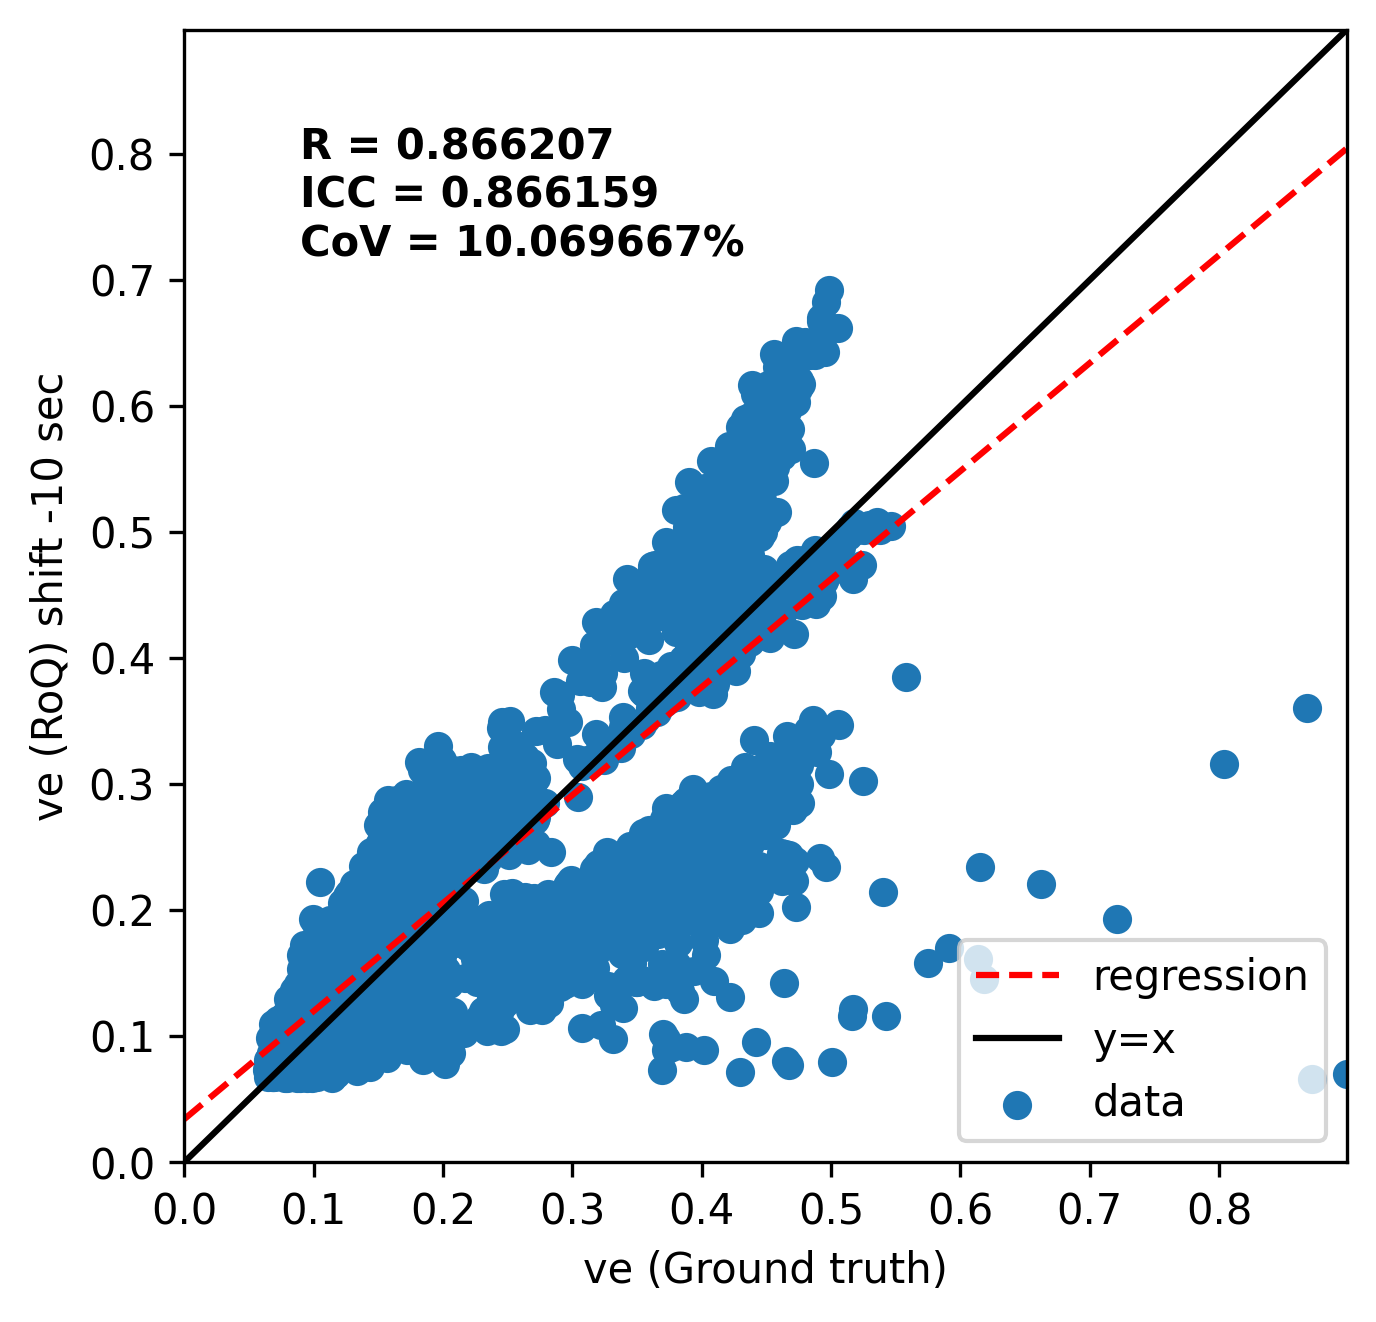

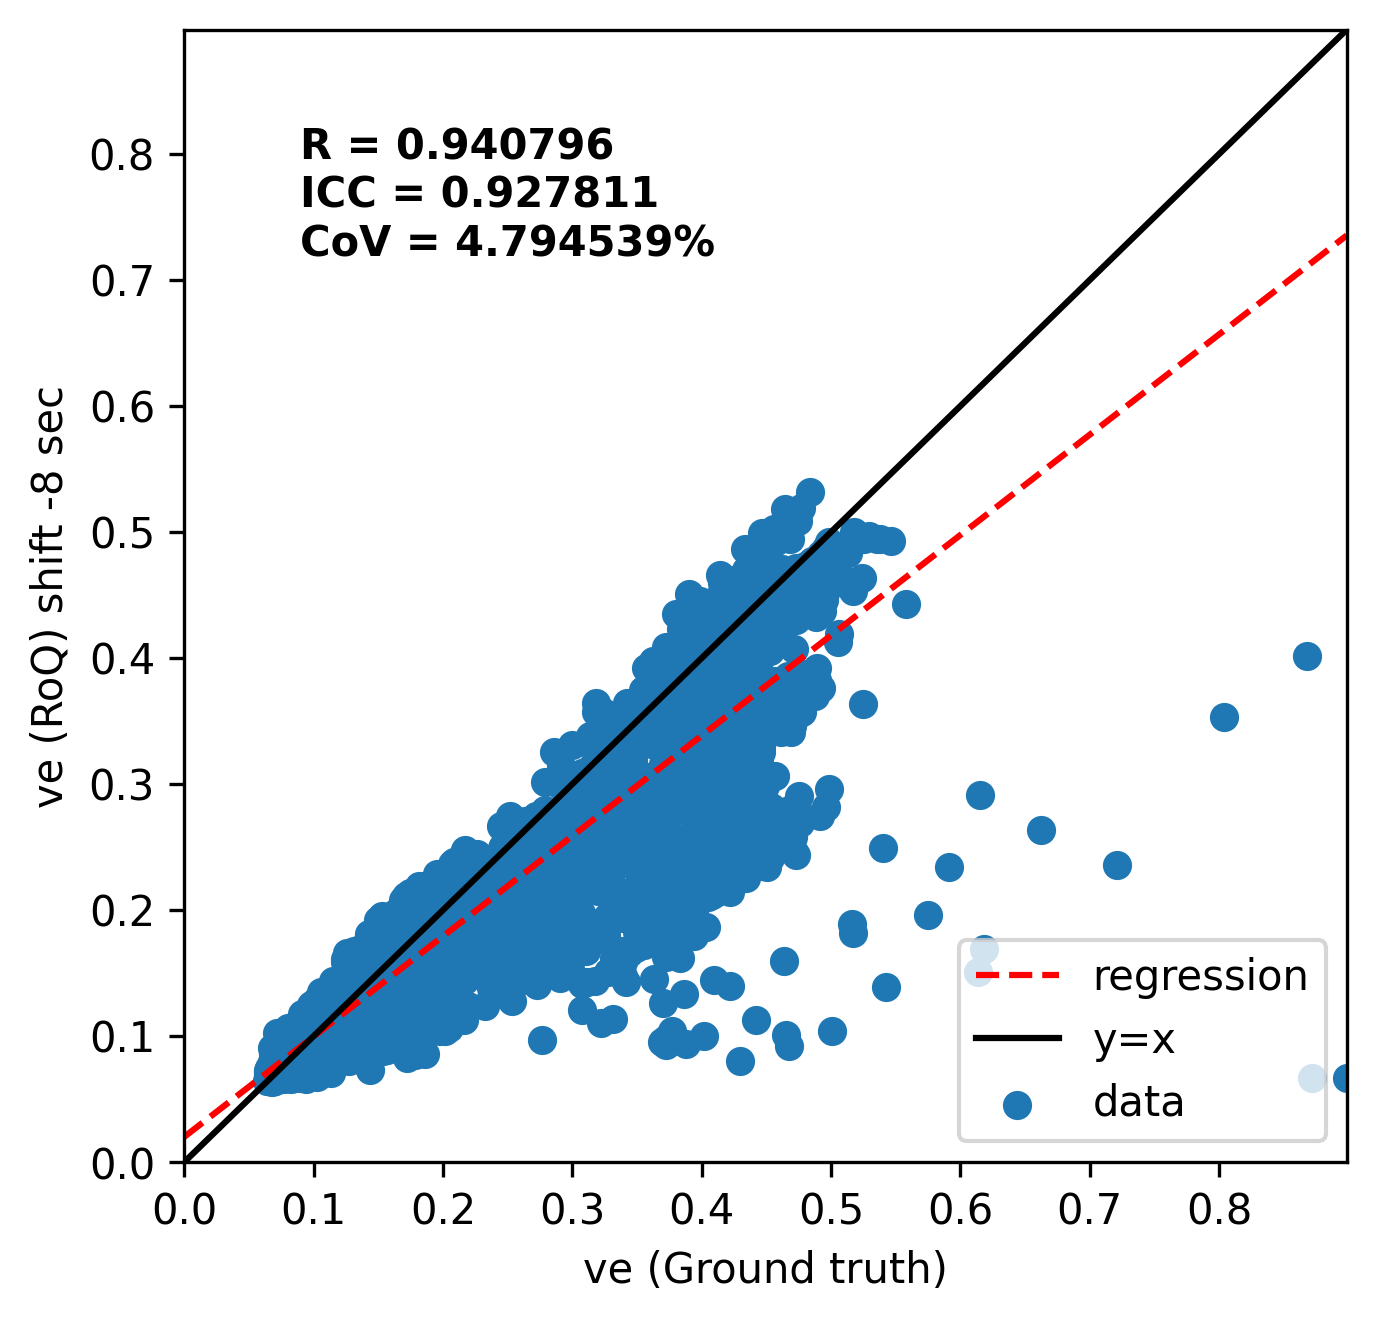

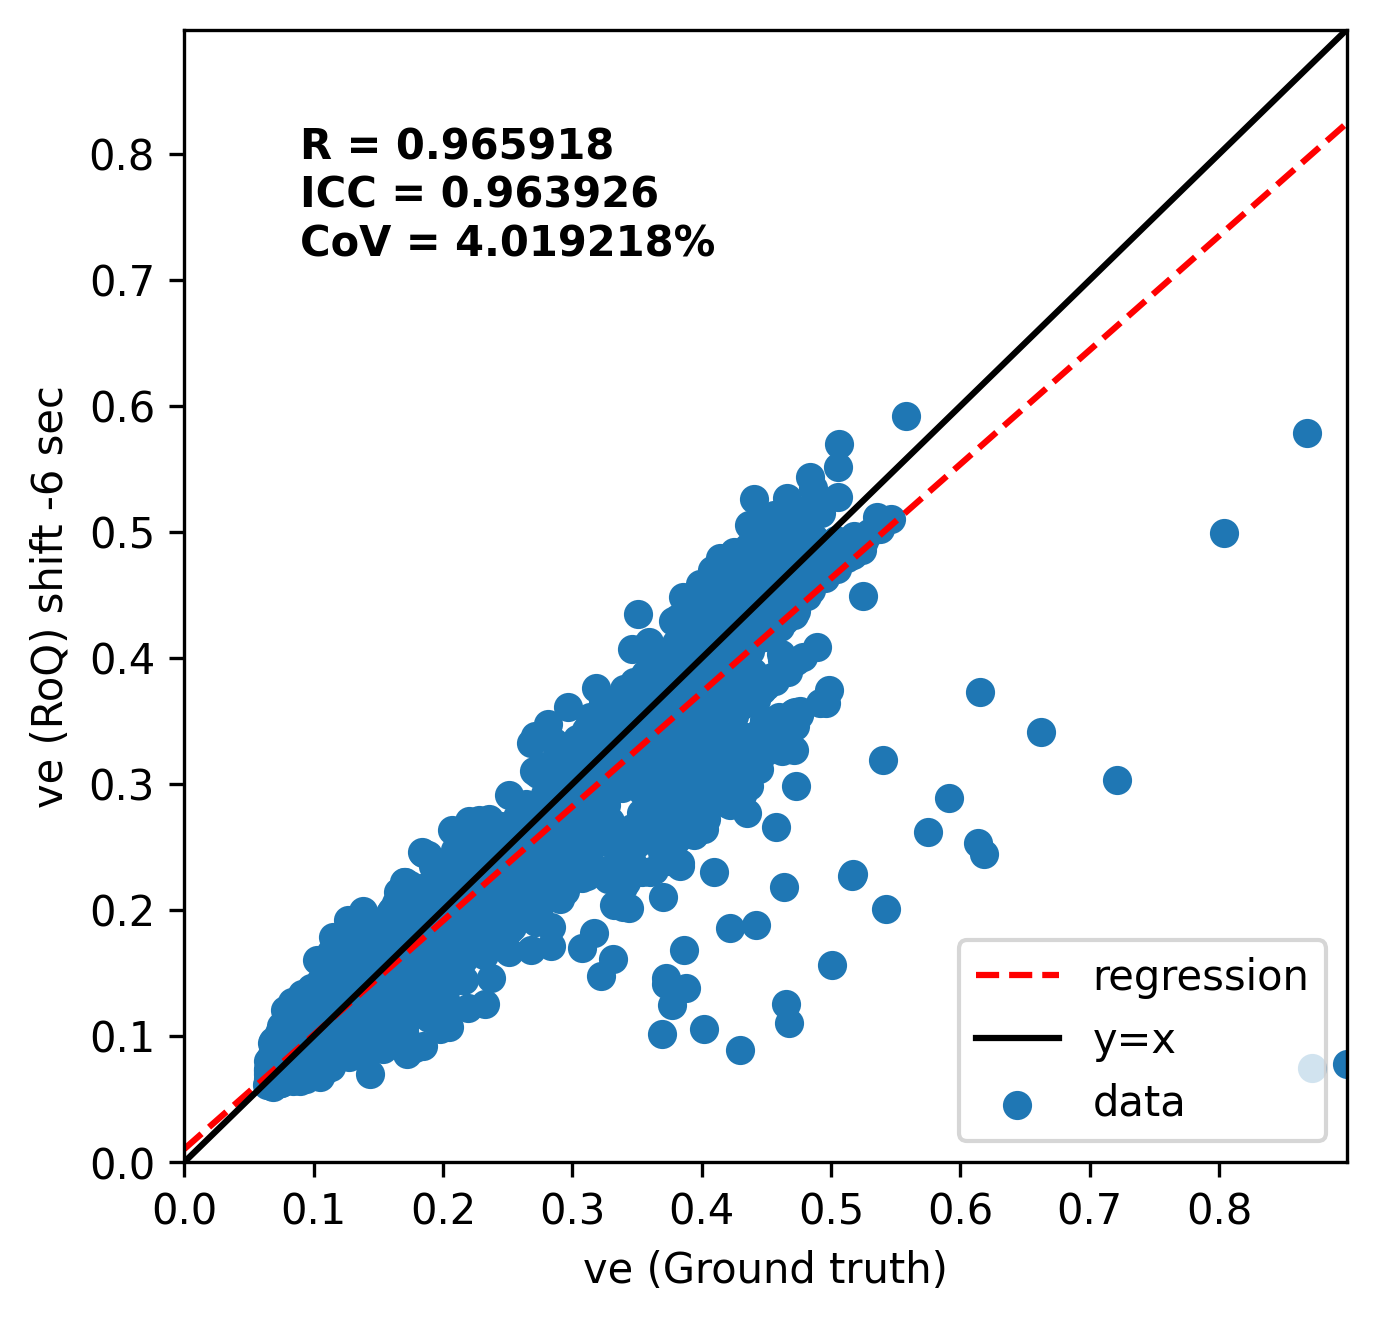

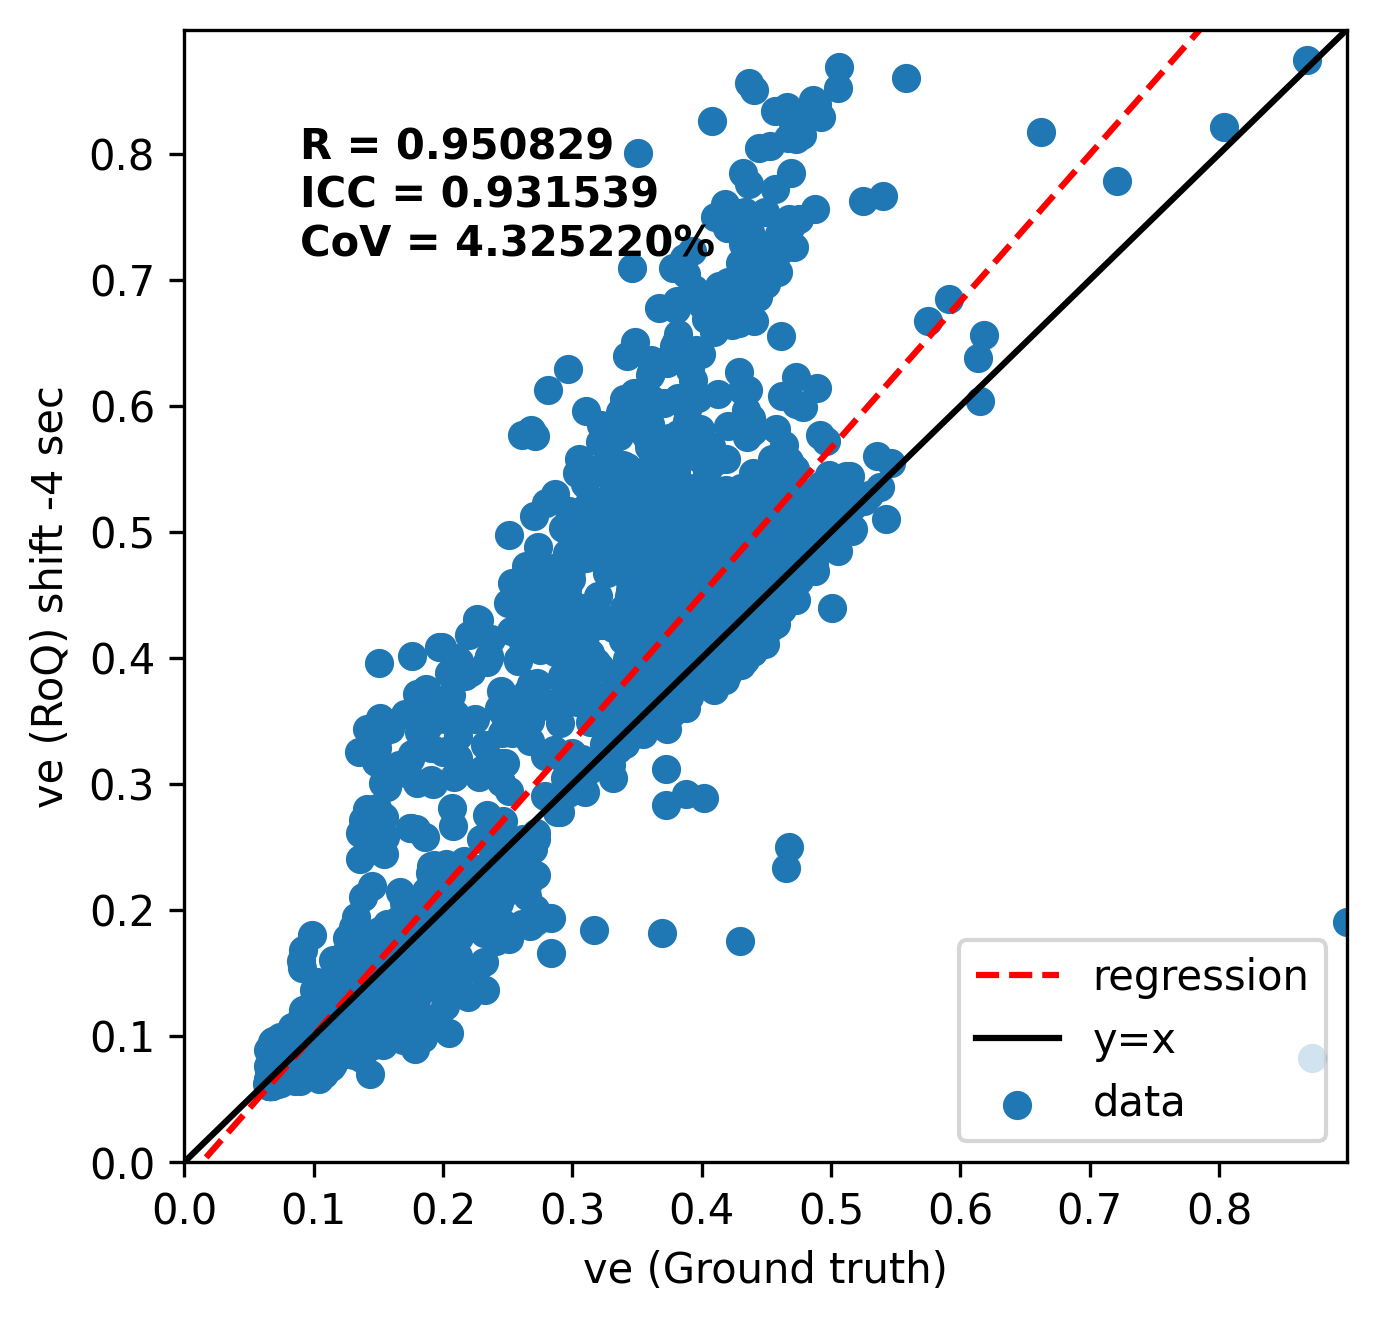

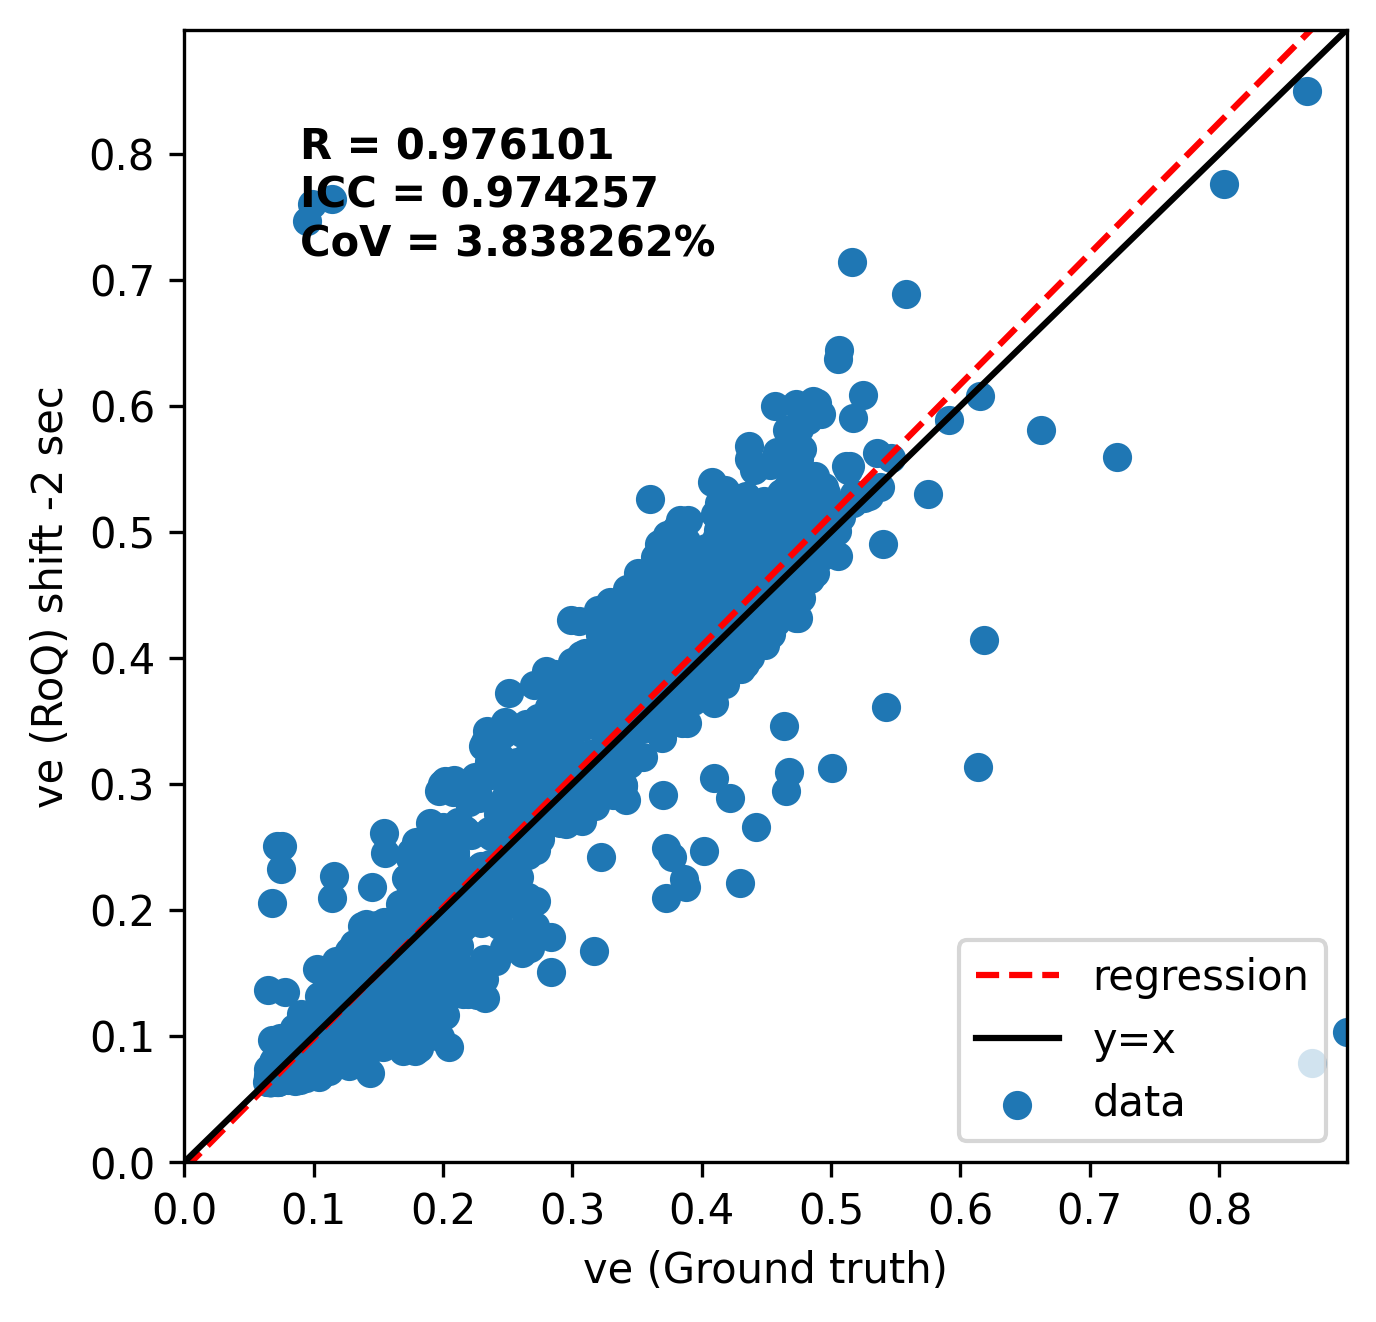

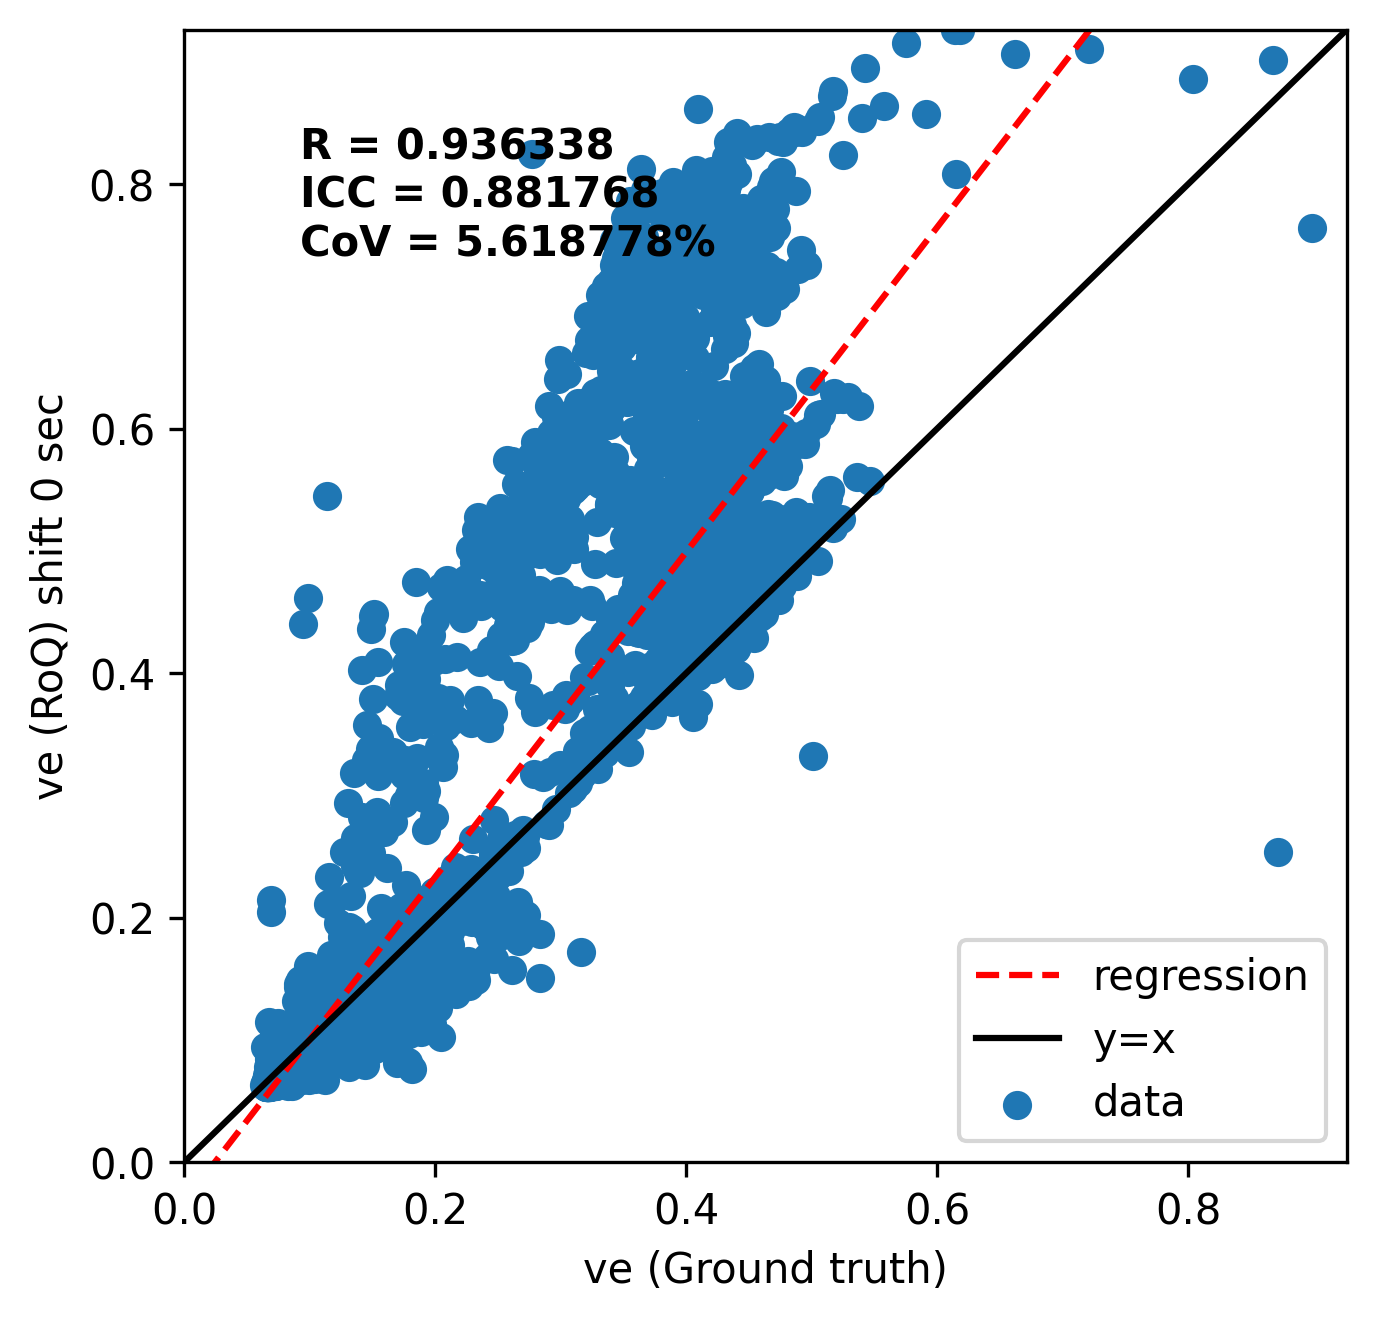

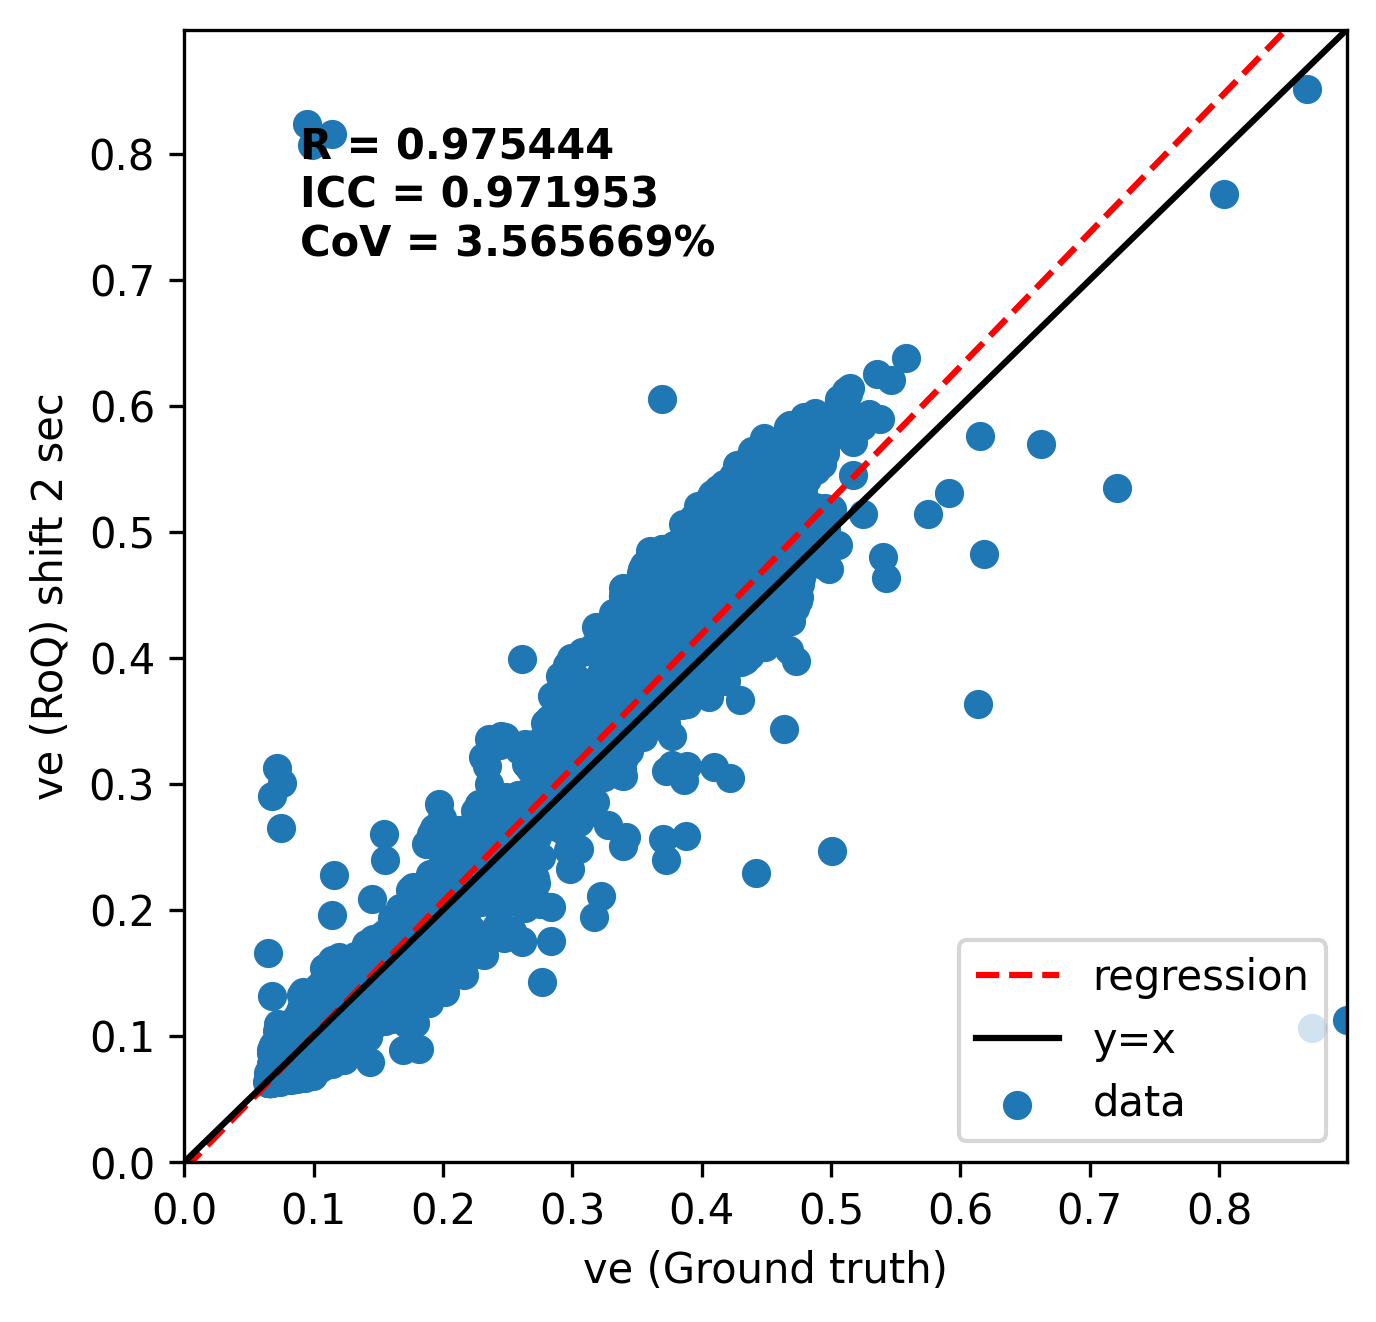

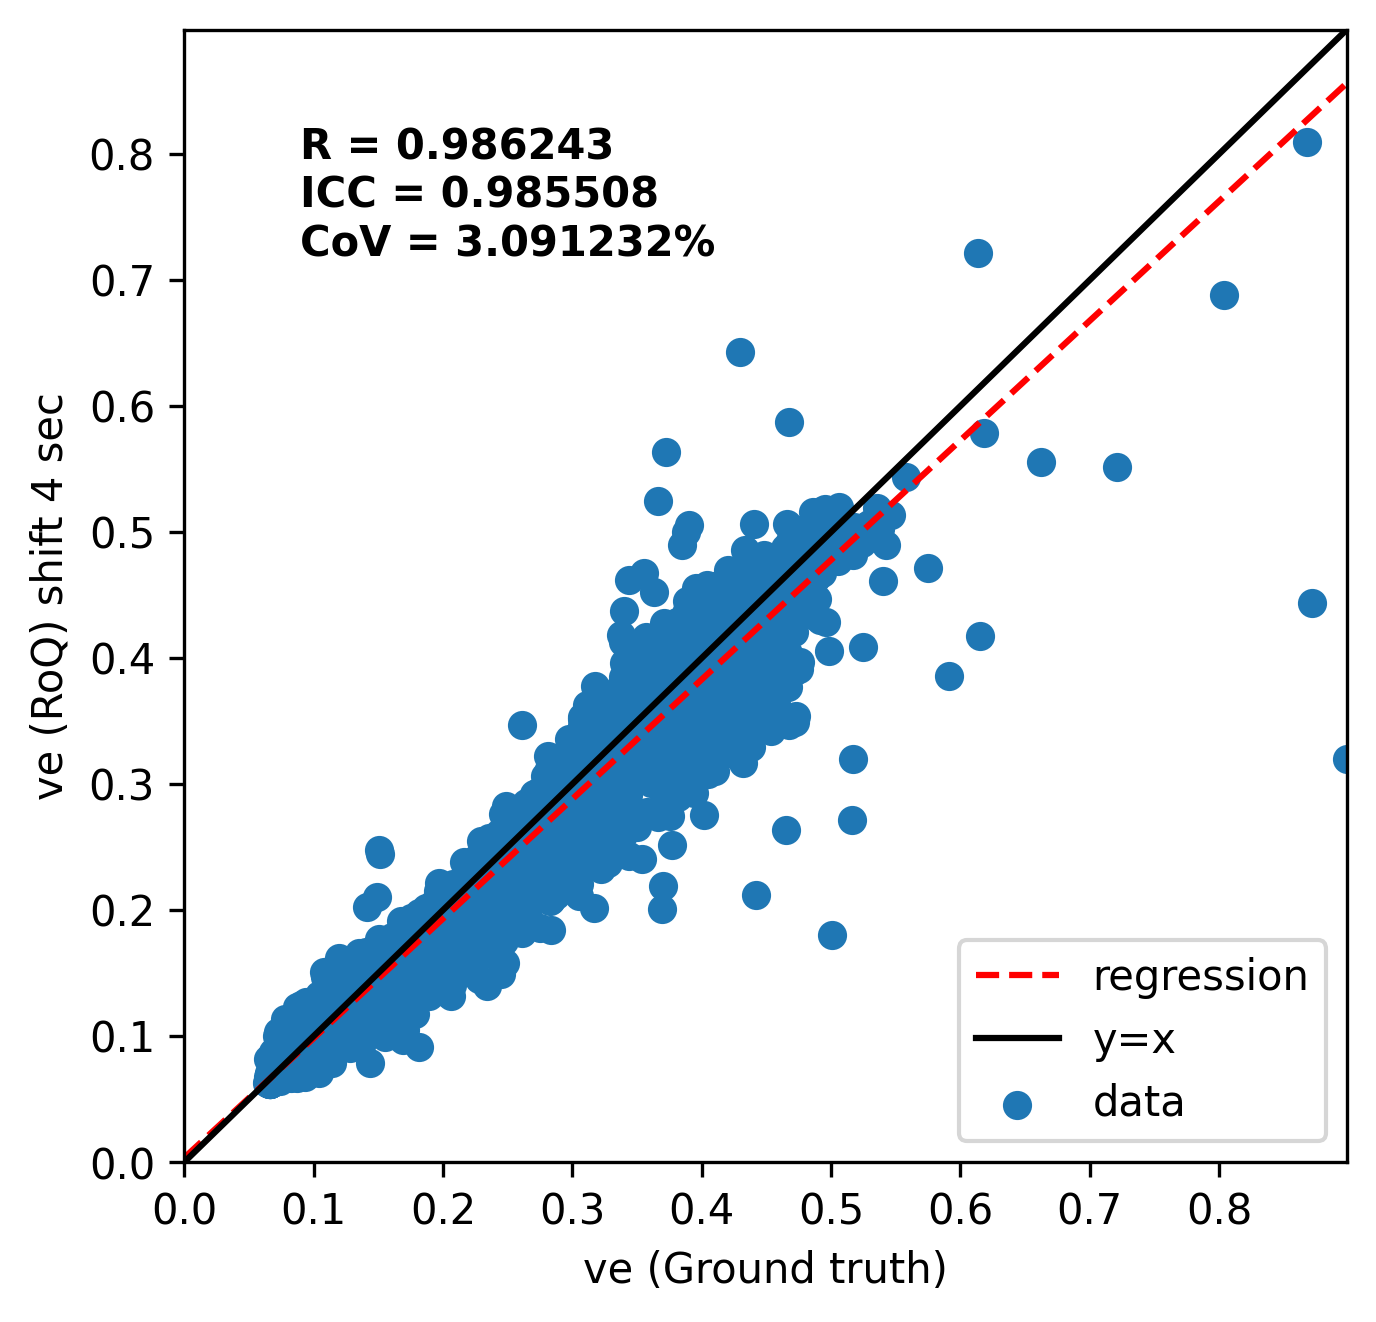

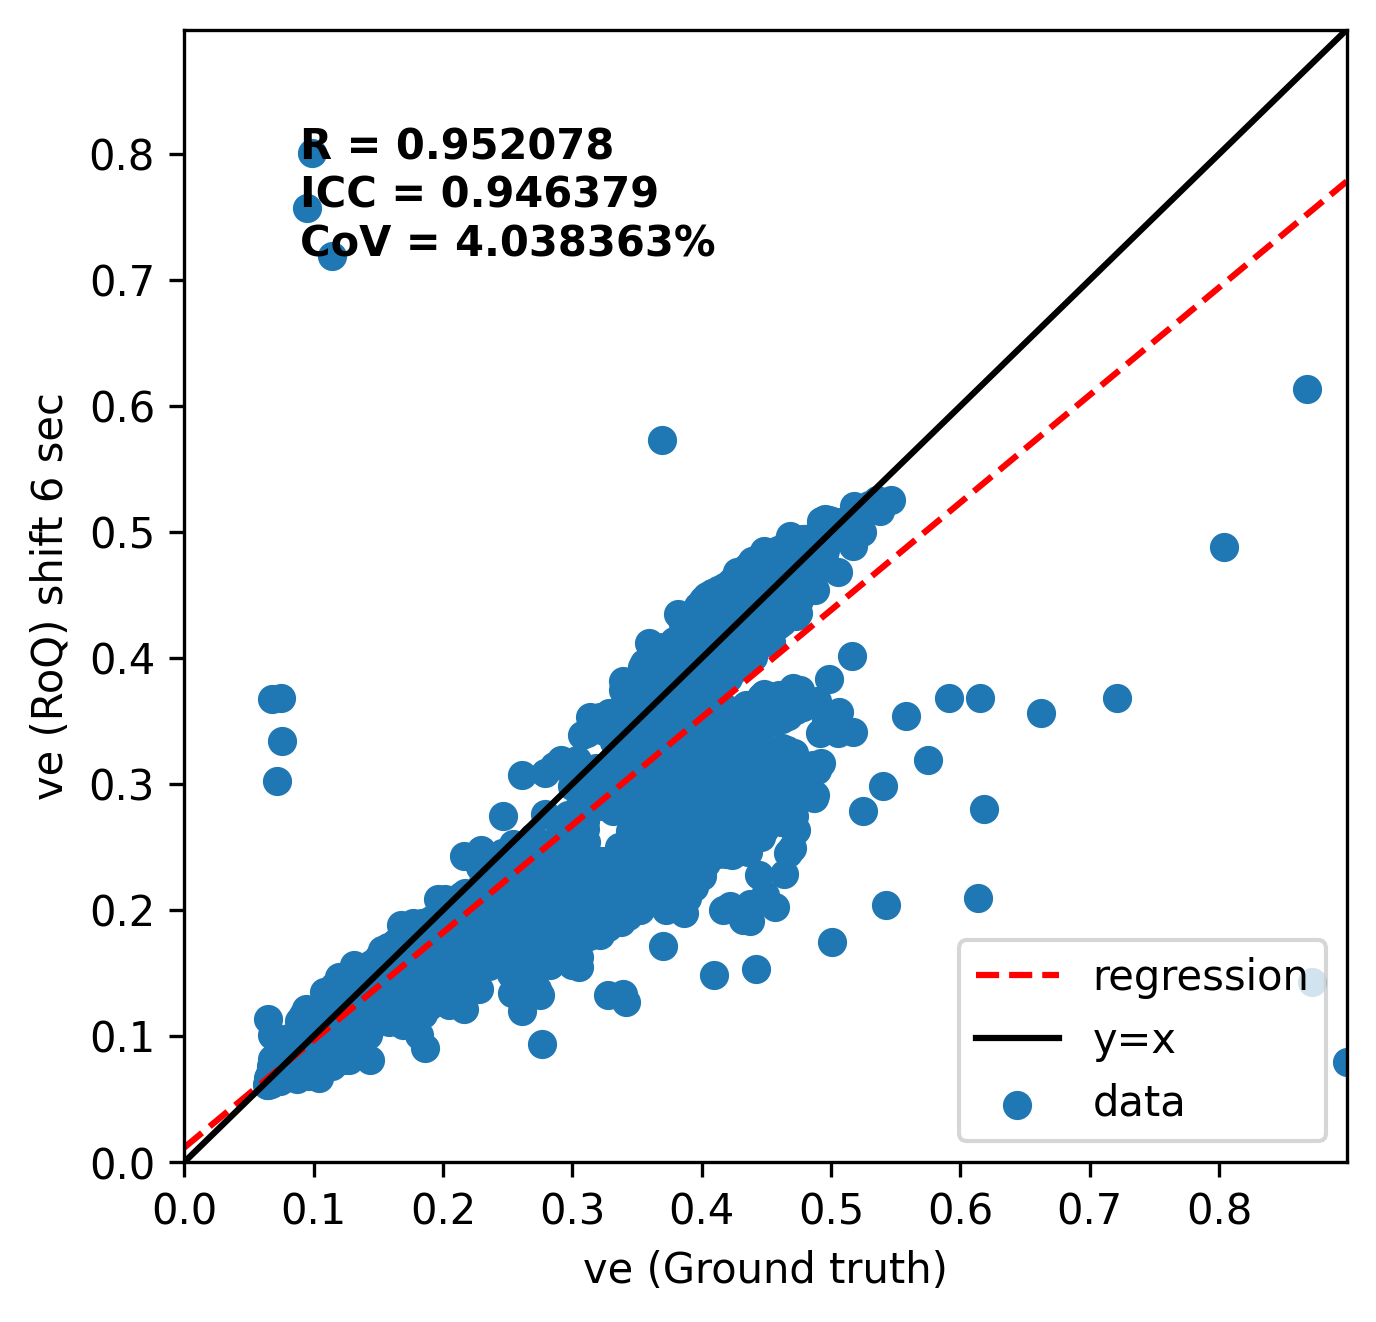

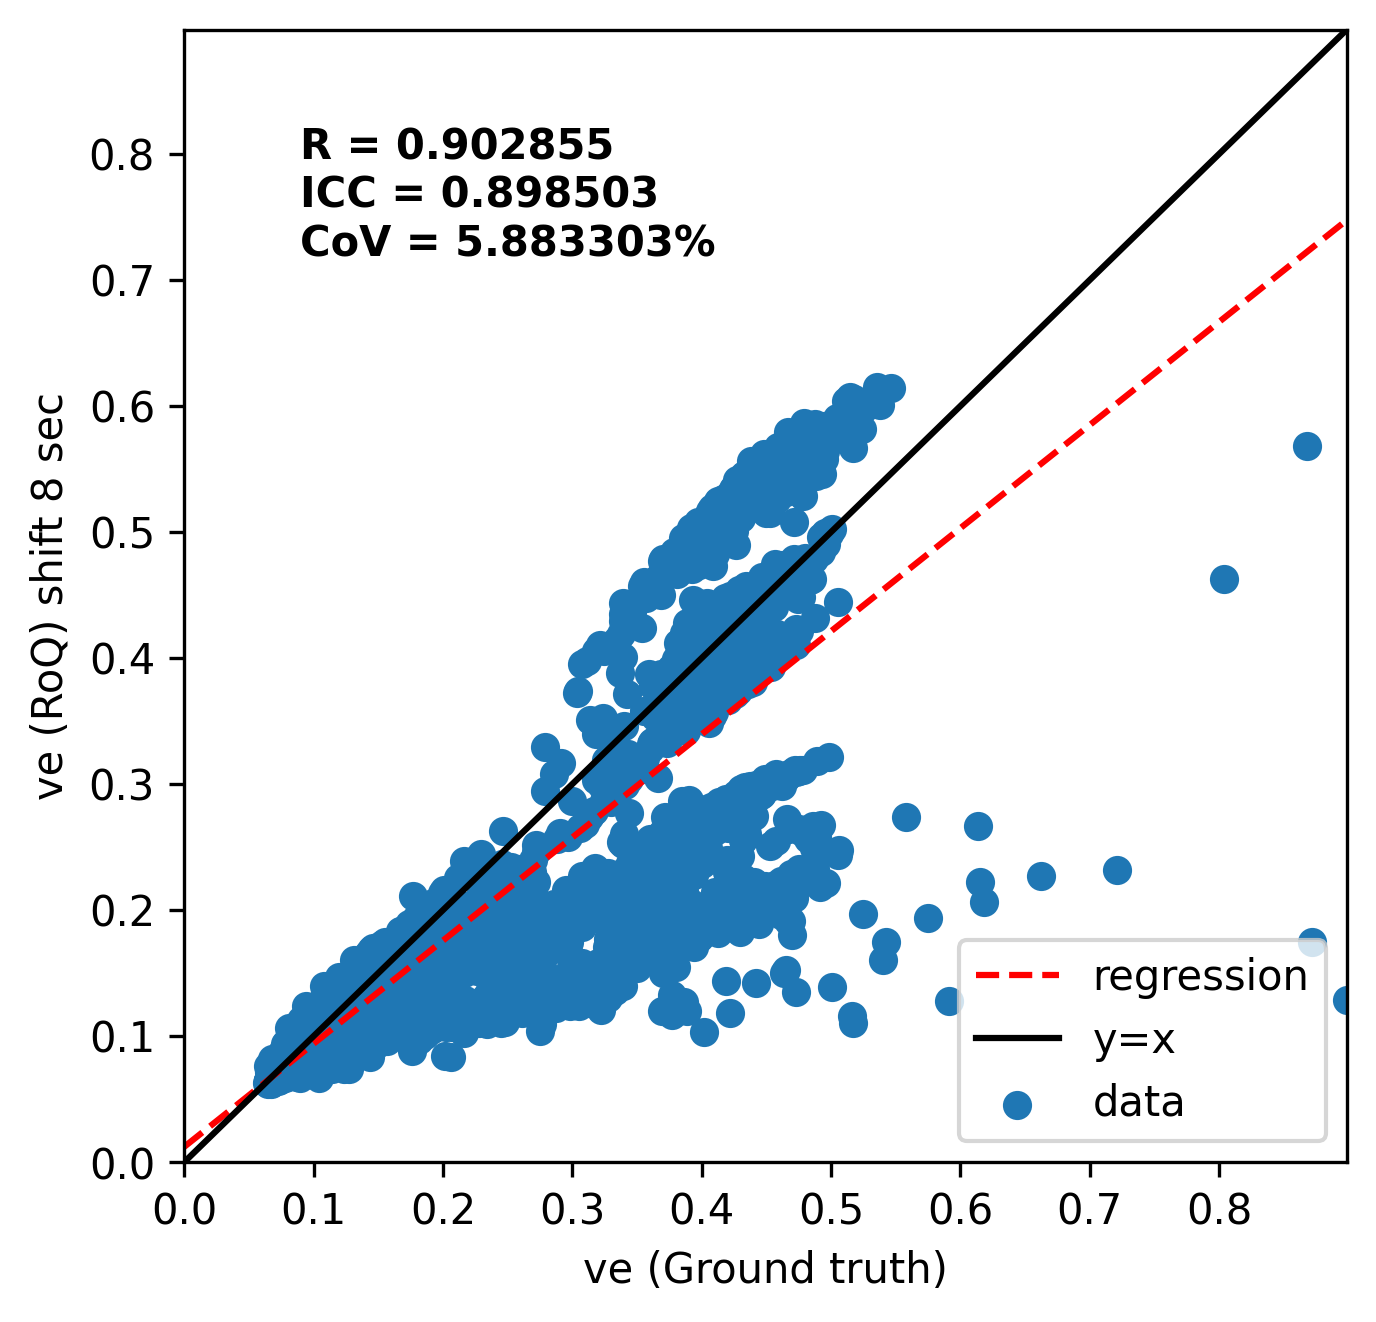

In [11]:
disp_name = {'RoQ':pk_roq_time_shifts}
pk_name = {'0':'ktrans','1':'kep','2':'ve'}
savepath = f"/home/chaowei/workspace/RoQ-DCE-DL/results/{prefix}"
for i in range(3):
    for j_name in ['RoQ']:
        for index,time_shift in enumerate(range(-10,10,2)):
#         for index,time_shift in enumerate([0]):
            smart_mkdir(savepath)
            MyPlot(pk_gt[:,i],disp_name[j_name][index][:,i],[f"{pk_name[str(i)]} (Ground truth)",f"{pk_name[str(i)]} ({j_name}) shift {time_shift} sec"],np.max((pk_gt[:,i],disp_name[j_name][index][:,i])),savepath,f"{pk_name[str(i)]}_{j_name}_{time_shift}",mode='do')

In [12]:
for index,time_shift in enumerate(range(-10,10,2)):
    np.save(f"{savepath}_{time_shift}.npy",pk_roq_time_shifts[index])